In [7]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format='retina'


import networkx as nx
import copy

import json
import matplotlib.pyplot as plt
import numpy as np
from itertools import islice
import heapq
from collections import Counter
import glob
import os
import shutil

import jsbeautifier
opts = jsbeautifier.default_options()
opts.indent_size = 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

class Prob:
    def __init__(self, P, H, W, L, F, obstacle_ratio=0.1, total_allocation_ratio=0.8, min_demands=3, rnd_seed=42, inc=0, min_demand_interval=1, asym_demand_prob=False, tri=False, diag = False, ramp_one=False, rnd_ramp_pos=False):
        self.P = P
        self.H = H
        self.W = W
        self.L = L
        self.F = F

        self.rnd_seed = rnd_seed

        np.random.seed(rnd_seed)

        self.obstacle_ratio = obstacle_ratio
        self.total_allocation_ratio = total_allocation_ratio
        self.min_demands = min_demands

        G_grid = self._create_multilayer_grid_graph(W, H, L, obstacle_ratio, inc, tri, diag, ramp_one, rnd_ramp_pos = rnd_ramp_pos)

        self.N = len(G_grid.nodes)

        self.K = self._generate_random_demands(P, self.N - 1, total_allocation_ratio=total_allocation_ratio, min_demands=min_demands, min_demand_interval=min_demand_interval, asym_demand_prob=asym_demand_prob)

        
        new_P, new_K, unused_ports = remove_unused_ports(P, self.K)
        if len(unused_ports) > 0:
            self.P = new_P
            self.K = new_K

        E = [
            (G_grid.nodes[u]['id'], G_grid.nodes[v]['id'])
            for (u,v) in G_grid.edges()
        ]

        self.E = E

        prob_info = {
            'N': self.N,
            'E': E,
            'P': self.P,
            'K': self.K,
            'F': F,
            'LB': self._get_LB()
        }

        
        self.G_grid = G_grid
        self.prob_info = prob_info



    def _create_multilayer_grid_graph(self, W, H, L, obstacle_ratio=0.1, inc=0, tri=False, diag = False, ramp_one=False, rnd_ramp_pos=False):
        """
        Create a multilayer grid graph with H layers, W columns, and F features.
        Each node in the grid has F features.
        """
        H_layer = [H + inc*i for i in range(L)]
        W_layer = [W + inc*i for i in range(L)]
        self.H_layer = H_layer
        self.W_layer = W_layer
        
        G = nx.Graph()
        for l in range(L):
            for h in range(H_layer[l]):
                for w in range(W_layer[l]):
                    if tri:
                        if h >= w:
                            if diag:
                                rndval = np.random.rand()
                                if rndval<0.15:
                                    if h < H_layer[l] - 1:
                                        G.add_edge((w, h, l), (w, h + 1, l))
                                    if h < H_layer[l] - 1 and w < W_layer[l] - 1:
                                        G.add_edge((w, h, l), (w + 1, h + 1, l))
                                elif rndval<=0.3:
                                    if w < W_layer[l] - 1:
                                        G.add_edge((w, h, l), (w + 1, h, l))
                                    if h < H_layer[l] - 1 and w < W_layer[l] - 1:
                                        G.add_edge((w, h, l), (w + 1, h + 1, l))
                                else:
                                    if w < W_layer[l] - 1:
                                        G.add_edge((w, h, l), (w + 1, h, l))
                                    if h < H_layer[l] - 1:
                                        G.add_edge((w, h, l), (w, h + 1, l))     
                            else:
                                if h < H_layer[l] - 1:
                                    G.add_edge((w, h, l), (w, h + 1, l))
                                if w < W_layer[l] - 1:
                                    G.add_edge((w, h, l), (w + 1, h, l))
                    else:
                        if diag:
                            rndval = np.random.rand()
                            if rndval<0.15:
                                if h < H_layer[l] - 1:
                                    G.add_edge((w, h, l), (w, h + 1, l))
                                if h < H_layer[l] - 1 and w < W_layer[l] - 1:
                                    G.add_edge((w, h, l), (w + 1, h + 1, l))
                            elif rndval<=0.3:
                                if w < W_layer[l] - 1:
                                    G.add_edge((w, h, l), (w + 1, h, l))
                                if h < H_layer[l] - 1 and w < W_layer[l] - 1:
                                    G.add_edge((w, h, l), (w + 1, h + 1, l))
                            else:
                                if w < W_layer[l] - 1:
                                    G.add_edge((w, h, l), (w + 1, h, l))
                                if h < H_layer[l] - 1:
                                    G.add_edge((w, h, l), (w, h + 1, l)) 
                        else:
                            if w < W_layer[l] - 1:
                                G.add_edge((w, h, l), (w + 1, h, l))
                            if h < H_layer[l] - 1:
                                G.add_edge((w, h, l), (w, h + 1, l))
                        
                            
        for x,y,z in G.nodes:
            G.nodes[(x,y,z)]['pos'] = (x, y + z * (H_layer[-1] * 1.2))
            G.nodes[(x,y,z)]['type'] = 'hold'

        # Ramps connecting layers
        for l in range(L):
            if l < L - 1:
                if tri or ramp_one:

                    if rnd_ramp_pos:
                        x = np.random.randint(0, min(W_layer[l], W_layer[l+1]))
                        y = H_layer[l]-1
                        ramp_nodes = [(x, y, l), (x, y, l+1)]
                    else:
                        ramp_nodes = [(int(W_layer[l]/2), H_layer[l]-1, l), (int(W_layer[l]/2), H_layer[l]-1, l+1)]

                    for n in ramp_nodes:
                        G.nodes[n]['type'] = 'ramp'
                    G.add_edge(ramp_nodes[0], ramp_nodes[1], ramp=True)
                else:
                    if rnd_ramp_pos:
                        x = np.random.choice(range(min(W_layer[l], W_layer[l+1])), 2, replace=False)
                        y = np.random.choice(range(min(H_layer[l], H_layer[l+1])), 2, replace=False)
                        ramp_nodes = [(x[0], y[0], l), (x[0], y[0], l+1), (x[1], y[1], l), (x[1], y[1], l+1)]
                    else:
                        ramp_nodes = [(int(W_layer[l]/2), 0, l), (int(W_layer[l]/2), 0, l+1), (int(W_layer[l]/2), H_layer[l]-1, l), (int(W_layer[l]/2), H_layer[l]-1, l+1)]
                    for n in ramp_nodes:
                        G.nodes[n]['type'] = 'ramp'

                    G.add_edge(ramp_nodes[0], ramp_nodes[1], ramp=True)
                    G.add_edge(ramp_nodes[2], ramp_nodes[3], ramp=True)
                

        gate_node = (0, 0, 0)

        G.nodes[gate_node]['type'] = 'gate'

        for x,y,z in G.nodes:
            if G.nodes[(x,y,z)]['type'] == 'hold':
                if obstacle_ratio > np.random.rand():
                    G.nodes[(x,y,z)]['type'] = 'obstacle'
                    G.remove_edges_from(list(G.edges((x,y,z))))

        nodes_by_distances = sorted([(l,n) for (n,l) in nx.shortest_path_length(G, source=(gate_node)).items()])

        for idx,(l,n) in enumerate(nodes_by_distances):
            G.nodes[n]['id'] = idx
            G.nodes[n]['distance'] = l

        # Remove nodes that are not reachable from the gate
        nodes_to_remove = []
        for n in G:
            if 'id' not in G.nodes[n]:
                nodes_to_remove.append(n)
        G.remove_nodes_from(nodes_to_remove)

        return G


    def _generate_random_demands(self, P, max_capa, total_allocation_ratio=0.8, min_demands=3, min_demand_interval=1, asym_demand_prob=False):
        """
        Generate random demands for P ports with a maximum capacity of max_capa.
        """

        K = {

        }

        loading_demands = np.zeros(P, dtype=int)
        unloading_demands = np.zeros(P, dtype=int)

        allocations = np.zeros(P, dtype=int)

        net_increase_demands = np.zeros(P, dtype=int)
        
        index=0
        while allocations.sum() < total_allocation_ratio * max_capa * P:
            # We put more weight on the early ports
            if asym_demand_prob:
                origin_probs = np.array([(P-1-p) for p in range(P-1)], dtype=float)
                origin_probs /= sum(origin_probs)
                origin = np.random.choice(range(P-1), p=origin_probs)
            else:
                origin = np.random.choice(range(P-1), p=[((P-1-p)/sum(range(1,P))) for p in range(P-1)])

            if asym_demand_prob:
                dest_min = min(origin+min_demand_interval,P-1)
                dest_max = P-1
                dest_probs = np.array([p+1 for p in range(dest_max-dest_min+1)], dtype=float)
                dest_probs /= sum(dest_probs)
                # print(dest_probs)
                destination = np.random.choice(range(dest_min, dest_max+1), size=1, p=dest_probs)[0]
            else:
                destination = np.random.randint(min(origin+min_demand_interval,P-1), P)
            
            
            capa_slack = max_capa - allocations[origin:destination+1].max()

            if capa_slack > 0:
                
                demand_to_add = np.random.randint(1, max(min(min_demands, capa_slack), 2))

                loading_demands[origin] += demand_to_add
                unloading_demands[destination] += demand_to_add

                if (origin, destination) not in K:
                    K[(origin, destination)] = demand_to_add
                else:
                    K[(origin, destination)] += demand_to_add

                allocations[origin:destination+1] += demand_to_add

        K = sorted(K.items())

        return K
    

    def _get_LB(self):
        """
        Get the lower bound of the problem.
        """

        G = nx.Graph()

        G.add_edges_from(self.E)

        sl = nx.shortest_path_length(G, source=0)
        sorted_dists = sorted(sl.values())[1:]

        F = self.F

        LB = 0

        for p in range(self.P):
            total_load_demands = sum([dem for ((o,d), dem) in self.K if o == p])
            LB += F * total_load_demands + sum(sorted_dists[:total_load_demands])
            
            total_unload_demands = sum([dem for ((o,d), dem) in self.K if d == p])
            LB += F * total_unload_demands + sum(sorted_dists[:total_unload_demands])

        return LB
        

    def save_to_file(self, filename, with_graph=True):
        """
        Save the graph to a file.
        """

        prob_info = copy.deepcopy(self.prob_info)

        if with_graph:
            prob_info['grid_graph'] = {
                'nodes': list(self.G_grid.nodes(data=True)),
                'edges': list(self.G_grid.edges(data=True))
            }


        with open(filename, "w") as f:
            f.write(jsbeautifier.beautify(json.dumps(prob_info, default=convert_to_int), opts))


    def draw_graph(self):

        grid = self.G_grid
        W = self.W
        H = self.H
        L = self.L
        H_layer = self.H_layer
        W_layer = self.W_layer

        ramp_nodes = [n for (n,attr) in grid.nodes.items() if attr['type'] == 'ramp']
        hold_nodes = [n for (n,attr) in grid.nodes.items() if attr['type'] == 'hold']
        gate_nodes = [n for (n,attr) in grid.nodes.items() if attr['type'] == 'gate']
        obstacle_nodes = [n for (n,attr) in grid.nodes.items() if attr['type'] == 'obstacle']

        plt.figure(figsize=(W_layer[-1], (H_layer[-1]) * L))

        node_size = 100

        nx.draw_networkx_nodes(grid, nodelist=ramp_nodes, pos=nx.get_node_attributes(grid, 'pos'), node_shape='s', node_color='blue', node_size=node_size)
        nx.draw_networkx_nodes(grid, nodelist=hold_nodes, pos=nx.get_node_attributes(grid, 'pos'), node_shape='o', node_color='green', node_size=node_size)
        nx.draw_networkx_nodes(grid, nodelist=gate_nodes, pos=nx.get_node_attributes(grid, 'pos'), node_shape='*', node_color='orange', node_size=node_size*3)


        ramp_edges = [(u, v) for (u, v, attr) in grid.edges(data=True) if 'ramp' in attr]
        common_edges = [(u, v) for (u, v, attr) in grid.edges(data=True) if 'ramp' not in attr]

        nx.draw_networkx_edges(grid, edgelist=common_edges, pos=nx.get_node_attributes(grid, 'pos'), alpha=0.5, edge_color='gray')
        nx.draw_networkx_edges(grid, edgelist=ramp_edges, pos=nx.get_node_attributes(grid, 'pos'), alpha=0.5, width=2, edge_color='gray', connectionstyle='arc3,rad=0.3', arrows=True, min_source_margin=0, min_target_margin=0, node_size=node_size)


        nx.draw_networkx_labels(grid, pos=nx.get_node_attributes(grid, 'pos'), labels=nx.get_node_attributes(grid, 'id'), font_size=6, font_color='white', verticalalignment='center', horizontalalignment='center')



def convert_to_int(obj):
    if isinstance(obj, np.int64):
        return int(obj)  
    raise TypeError(f"Type {type(obj)} not serializable")
  



def remove_unused_ports(P, K):

    notused_ports = []

    for p in range(P):
        loading_demands = [((o,d), r) for ((o,d), r) in K if o == p]
        unloading_demands = [((o,d), r) for ((o,d), r) in K if d == p]
        if len(loading_demands) == 0 and len(unloading_demands) == 0:
            notused_ports.append(p)

    new_K = []
    if len(notused_ports) > 0:
        new_P = P - len(notused_ports)
        for ((o,d), r) in K:
            new_o = o - len([p for p in notused_ports if p <= o])
            new_d = d - len([p for p in notused_ports if p <= d])
            new_K.append(
                [[new_o, new_d], r]
            )
                
        return new_P, new_K, notused_ports
    else:
        return P, K, notused_ports

93

[[[0, 4], 17],
 [[0, 12], 11],
 [[0, 16], 7],
 [[1, 11], 12],
 [[1, 16], 5],
 [[2, 14], 19],
 [[3, 8], 14],
 [[5, 10], 1],
 [[5, 15], 16],
 [[6, 16], 1],
 [[7, 16], 5],
 [[9, 13], 14],
 [[9, 16], 1]]

/var/folders/8z/0zlwgr2155546qbdsj5hq4zh0000gn/T/ipykernel_46853/2351706303.py:302: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(grid, edgelist=ramp_edges, pos=nx.get_node_attributes(grid, 'pos'), alpha=0.5, width=2, edge_color='gray', connectionstyle='arc3,rad=0.3', arrows=True, min_source_margin=0, min_target_margin=0, node_size=node_size)


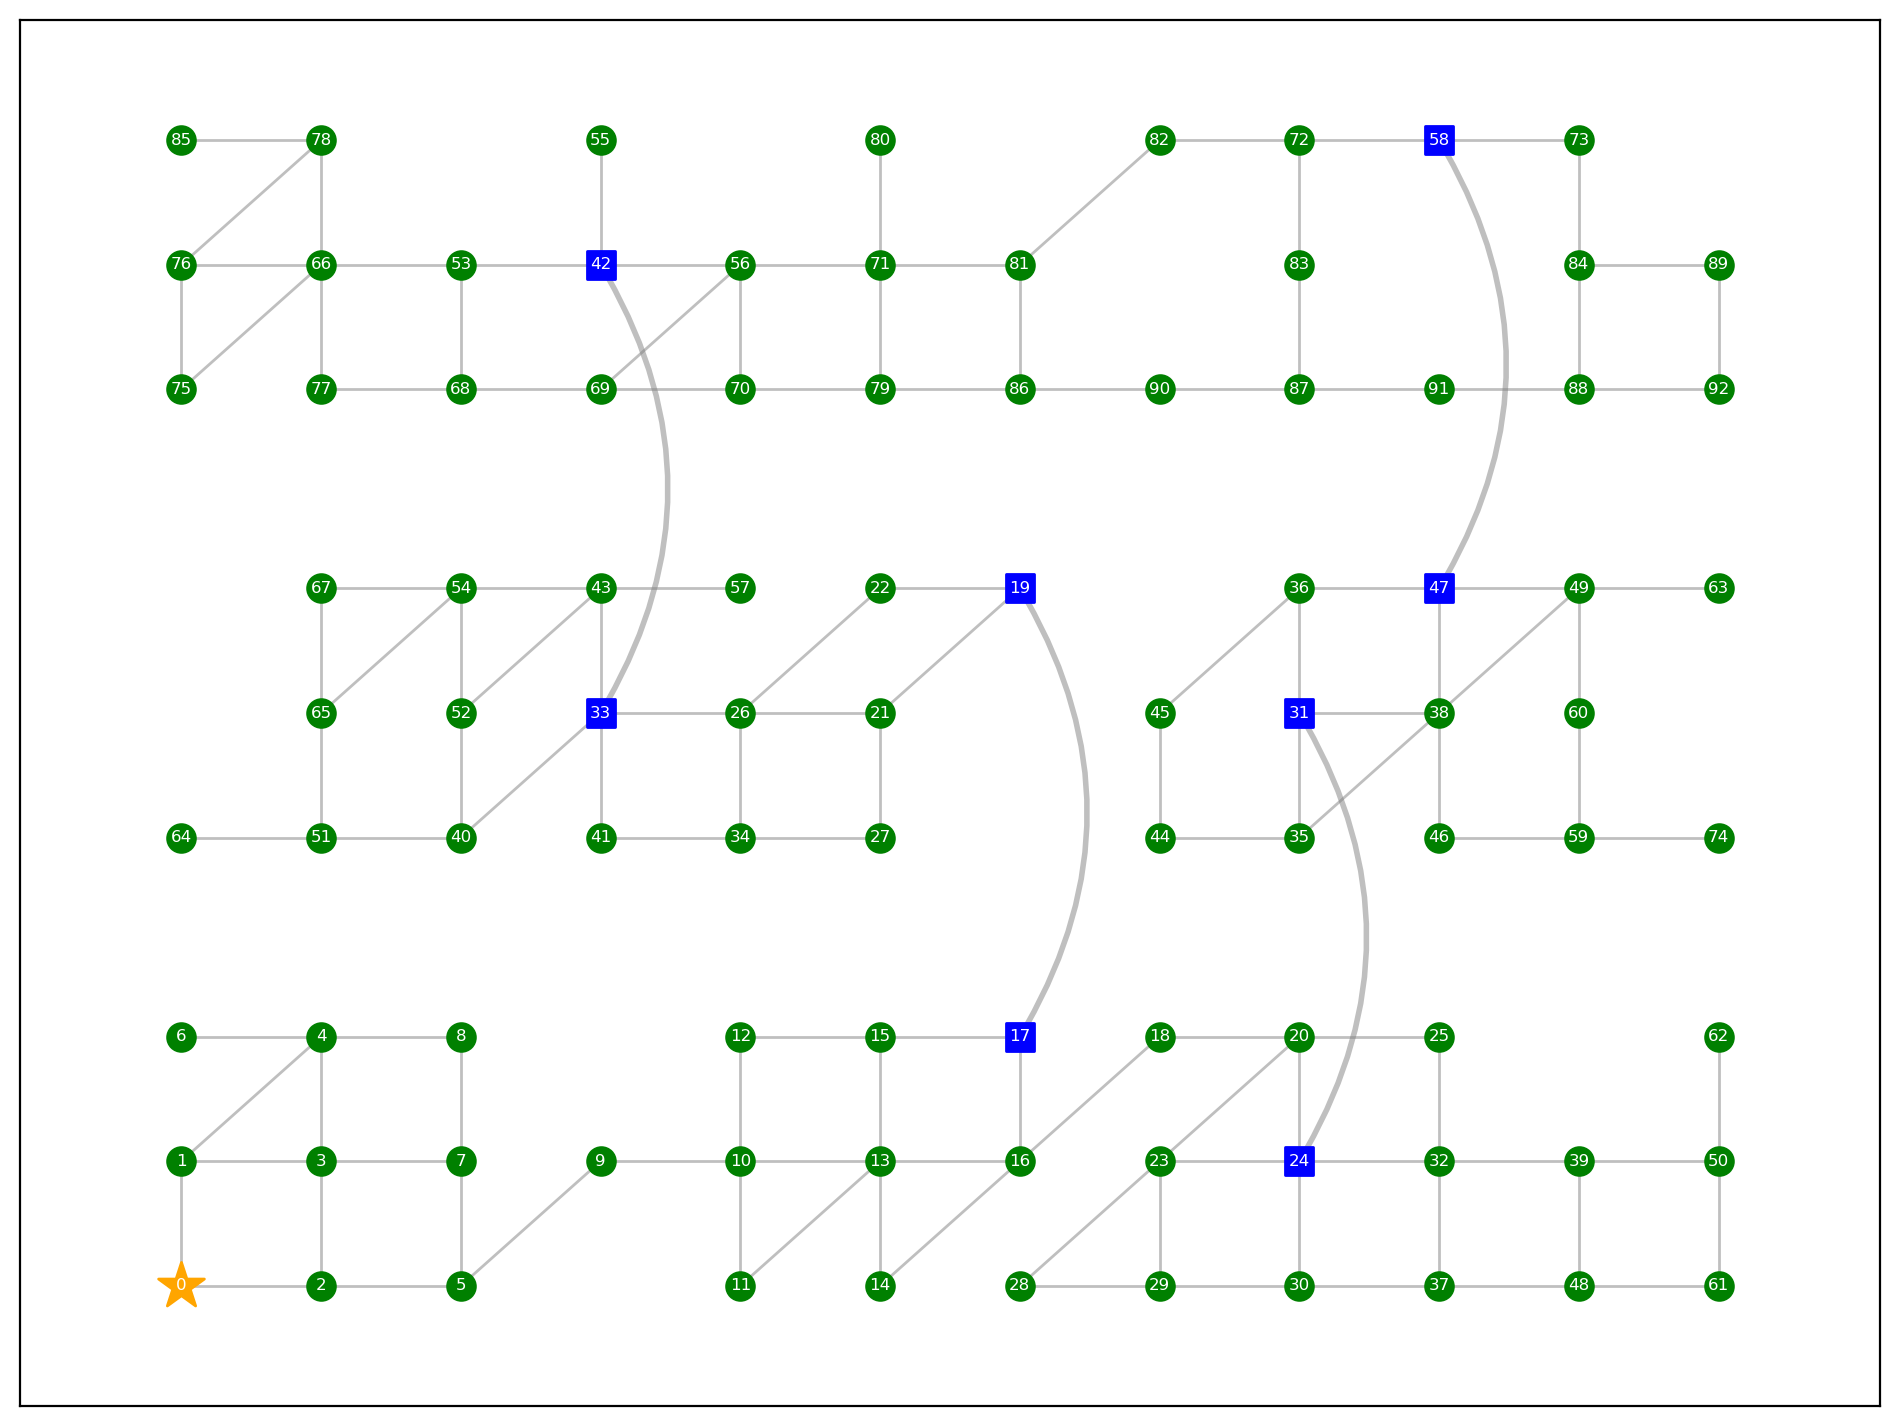

In [94]:

# N=84, rehandling required
P, H, W, L, F = 25, 3, 12, 3, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.1, total_allocation_ratio=0.8, min_demands=20, rnd_seed=1, inc=0, min_demand_interval=4, tri = False, diag = True, ramp_one=False, rnd_ramp_pos=True, asym_demand_prob=True)

display(prob.prob_info['N'])
display(prob.prob_info['K'])
prob.draw_graph()


prob.save_to_file("stage3_test/test.json", with_graph=True)



254

[[[0, 5], 1],
 [[0, 9], 13],
 [[0, 10], 1],
 [[0, 11], 11],
 [[0, 15], 1],
 [[1, 6], 7],
 [[1, 8], 4],
 [[1, 12], 14],
 [[1, 15], 19],
 [[1, 18], 15],
 [[2, 8], 3],
 [[2, 9], 9],
 [[2, 10], 5],
 [[2, 16], 3],
 [[3, 8], 8],
 [[3, 10], 11],
 [[3, 14], 11],
 [[3, 17], 7],
 [[3, 18], 15],
 [[4, 11], 10],
 [[4, 14], 9],
 [[4, 17], 7],
 [[5, 11], 1],
 [[5, 14], 7],
 [[5, 16], 16],
 [[5, 17], 2],
 [[5, 18], 3],
 [[6, 16], 3],
 [[6, 17], 14],
 [[6, 18], 1],
 [[7, 12], 1],
 [[7, 18], 7],
 [[8, 16], 12],
 [[9, 13], 12],
 [[9, 15], 1],
 [[9, 16], 8],
 [[10, 16], 12],
 [[10, 17], 8],
 [[11, 17], 17],
 [[11, 18], 6],
 [[12, 17], 22],
 [[13, 18], 1],
 [[14, 18], 26],
 [[15, 18], 23],
 [[16, 18], 22],
 [[17, 18], 19]]

256

[((0, 4), 12),
 ((0, 5), 1),
 ((0, 7), 16),
 ((0, 8), 5),
 ((0, 10), 1),
 ((0, 11), 19),
 ((0, 13), 13),
 ((1, 6), 1),
 ((1, 8), 8),
 ((1, 9), 8),
 ((1, 10), 2),
 ((1, 13), 10),
 ((1, 16), 3),
 ((2, 8), 15),
 ((2, 14), 10),
 ((2, 16), 6),
 ((3, 10), 1),
 ((3, 11), 11),
 ((3, 14), 7),
 ((3, 17), 16),
 ((4, 11), 10),
 ((4, 14), 13),
 ((4, 16), 26),
 ((4, 17), 13),
 ((5, 13), 4),
 ((6, 13), 3),
 ((6, 14), 15),
 ((6, 17), 17),
 ((8, 14), 1),
 ((8, 16), 16),
 ((9, 14), 3),
 ((9, 15), 14),
 ((9, 16), 13),
 ((10, 16), 2),
 ((10, 17), 6),
 ((11, 15), 1),
 ((11, 16), 2),
 ((11, 17), 1),
 ((12, 17), 14),
 ((13, 17), 26),
 ((15, 17), 47),
 ((16, 17), 7)]

90

[[[0, 3], 19],
 [[0, 5], 18],
 [[0, 7], 8],
 [[1, 5], 25],
 [[2, 3], 1],
 [[2, 4], 7],
 [[2, 7], 11],
 [[4, 7], 20],
 [[5, 7], 3],
 [[6, 7], 9]]

106

[[[0, 3], 2],
 [[0, 4], 19],
 [[0, 6], 9],
 [[1, 5], 4],
 [[1, 7], 16],
 [[1, 8], 36],
 [[2, 7], 13],
 [[2, 8], 1],
 [[3, 8], 1],
 [[5, 8], 20],
 [[7, 8], 18]]

110

[((0, 4), 9),
 ((0, 6), 1),
 ((0, 7), 1),
 ((0, 12), 9),
 ((0, 14), 15),
 ((1, 5), 6),
 ((1, 10), 3),
 ((2, 12), 1),
 ((3, 9), 13),
 ((3, 12), 17),
 ((4, 8), 1),
 ((4, 10), 19),
 ((4, 14), 5),
 ((5, 13), 6),
 ((6, 14), 18),
 ((9, 14), 3),
 ((10, 14), 11),
 ((11, 14), 8),
 ((12, 14), 16),
 ((13, 14), 8)]

56

[((0, 6), 1),
 ((1, 4), 16),
 ((1, 5), 18),
 ((1, 9), 5),
 ((2, 5), 6),
 ((3, 6), 1),
 ((3, 9), 2),
 ((3, 11), 6),
 ((5, 8), 15),
 ((5, 11), 1),
 ((6, 9), 1),
 ((7, 10), 1),
 ((8, 11), 22),
 ((9, 11), 17),
 ((10, 11), 6)]

144

[((0, 3), 40),
 ((0, 6), 5),
 ((0, 7), 10),
 ((0, 8), 12),
 ((1, 4), 5),
 ((1, 5), 2),
 ((1, 6), 6),
 ((1, 9), 19),
 ((2, 7), 13),
 ((2, 8), 1),
 ((2, 9), 13),
 ((3, 9), 8),
 ((4, 7), 17),
 ((4, 8), 15),
 ((4, 9), 17),
 ((6, 9), 1),
 ((7, 9), 17)]

115

[((0, 5), 4),
 ((0, 14), 15),
 ((0, 18), 15),
 ((1, 10), 23),
 ((2, 7), 18),
 ((3, 8), 9),
 ((3, 19), 2),
 ((4, 10), 16),
 ((4, 15), 11),
 ((6, 11), 1),
 ((6, 19), 4),
 ((8, 13), 12),
 ((8, 15), 1),
 ((9, 14), 14),
 ((11, 17), 16),
 ((12, 17), 17),
 ((12, 19), 7),
 ((14, 19), 9),
 ((15, 19), 17),
 ((16, 19), 12)]

63

[((0, 8), 1),
 ((0, 11), 2),
 ((1, 6), 4),
 ((1, 11), 1),
 ((2, 6), 19),
 ((2, 8), 4),
 ((2, 9), 4),
 ((3, 9), 1),
 ((3, 11), 17),
 ((4, 9), 2),
 ((4, 15), 3),
 ((5, 14), 4),
 ((7, 13), 2),
 ((8, 16), 19),
 ((10, 14), 14),
 ((12, 16), 4),
 ((13, 16), 10),
 ((14, 16), 8),
 ((15, 16), 17)]

54

[[[0, 3], 11],
 [[0, 4], 1],
 [[0, 10], 7],
 [[1, 5], 2],
 [[2, 7], 4],
 [[2, 8], 8],
 [[3, 11], 10],
 [[4, 10], 16],
 [[4, 13], 5],
 [[5, 9], 1],
 [[6, 12], 2],
 [[8, 11], 1],
 [[9, 11], 10],
 [[9, 12], 1],
 [[10, 13], 1],
 [[11, 13], 6],
 [[12, 13], 27]]

198

[((0, 5), 14),
 ((0, 7), 1),
 ((0, 8), 2),
 ((0, 10), 2),
 ((0, 13), 22),
 ((0, 14), 15),
 ((1, 5), 17),
 ((2, 9), 5),
 ((3, 7), 16),
 ((3, 9), 14),
 ((3, 13), 14),
 ((3, 14), 10),
 ((4, 11), 14),
 ((4, 12), 12),
 ((4, 13), 19),
 ((5, 13), 15),
 ((6, 12), 36),
 ((9, 13), 17),
 ((9, 14), 1),
 ((10, 14), 16),
 ((11, 14), 6),
 ((12, 14), 14),
 ((13, 14), 45)]

149

[((0, 5), 28),
 ((0, 6), 8),
 ((0, 7), 6),
 ((0, 10), 11),
 ((0, 12), 3),
 ((1, 9), 25),
 ((1, 10), 7),
 ((1, 12), 8),
 ((2, 8), 1),
 ((2, 10), 9),
 ((2, 11), 1),
 ((2, 12), 9),
 ((3, 6), 5),
 ((3, 8), 2),
 ((3, 10), 6),
 ((4, 8), 5),
 ((4, 9), 6),
 ((4, 11), 1),
 ((6, 12), 30),
 ((7, 11), 14),
 ((7, 12), 4),
 ((8, 12), 4),
 ((9, 12), 10),
 ((10, 12), 24),
 ((11, 12), 18)]

68

[((0, 5), 6),
 ((0, 7), 12),
 ((1, 7), 13),
 ((2, 7), 27),
 ((3, 7), 7),
 ((4, 7), 2),
 ((6, 7), 2)]

93

[[[0, 4], 17],
 [[0, 12], 11],
 [[0, 16], 7],
 [[1, 11], 12],
 [[1, 16], 5],
 [[2, 14], 19],
 [[3, 8], 14],
 [[5, 10], 1],
 [[5, 15], 16],
 [[6, 16], 1],
 [[7, 16], 5],
 [[9, 13], 14],
 [[9, 16], 1]]

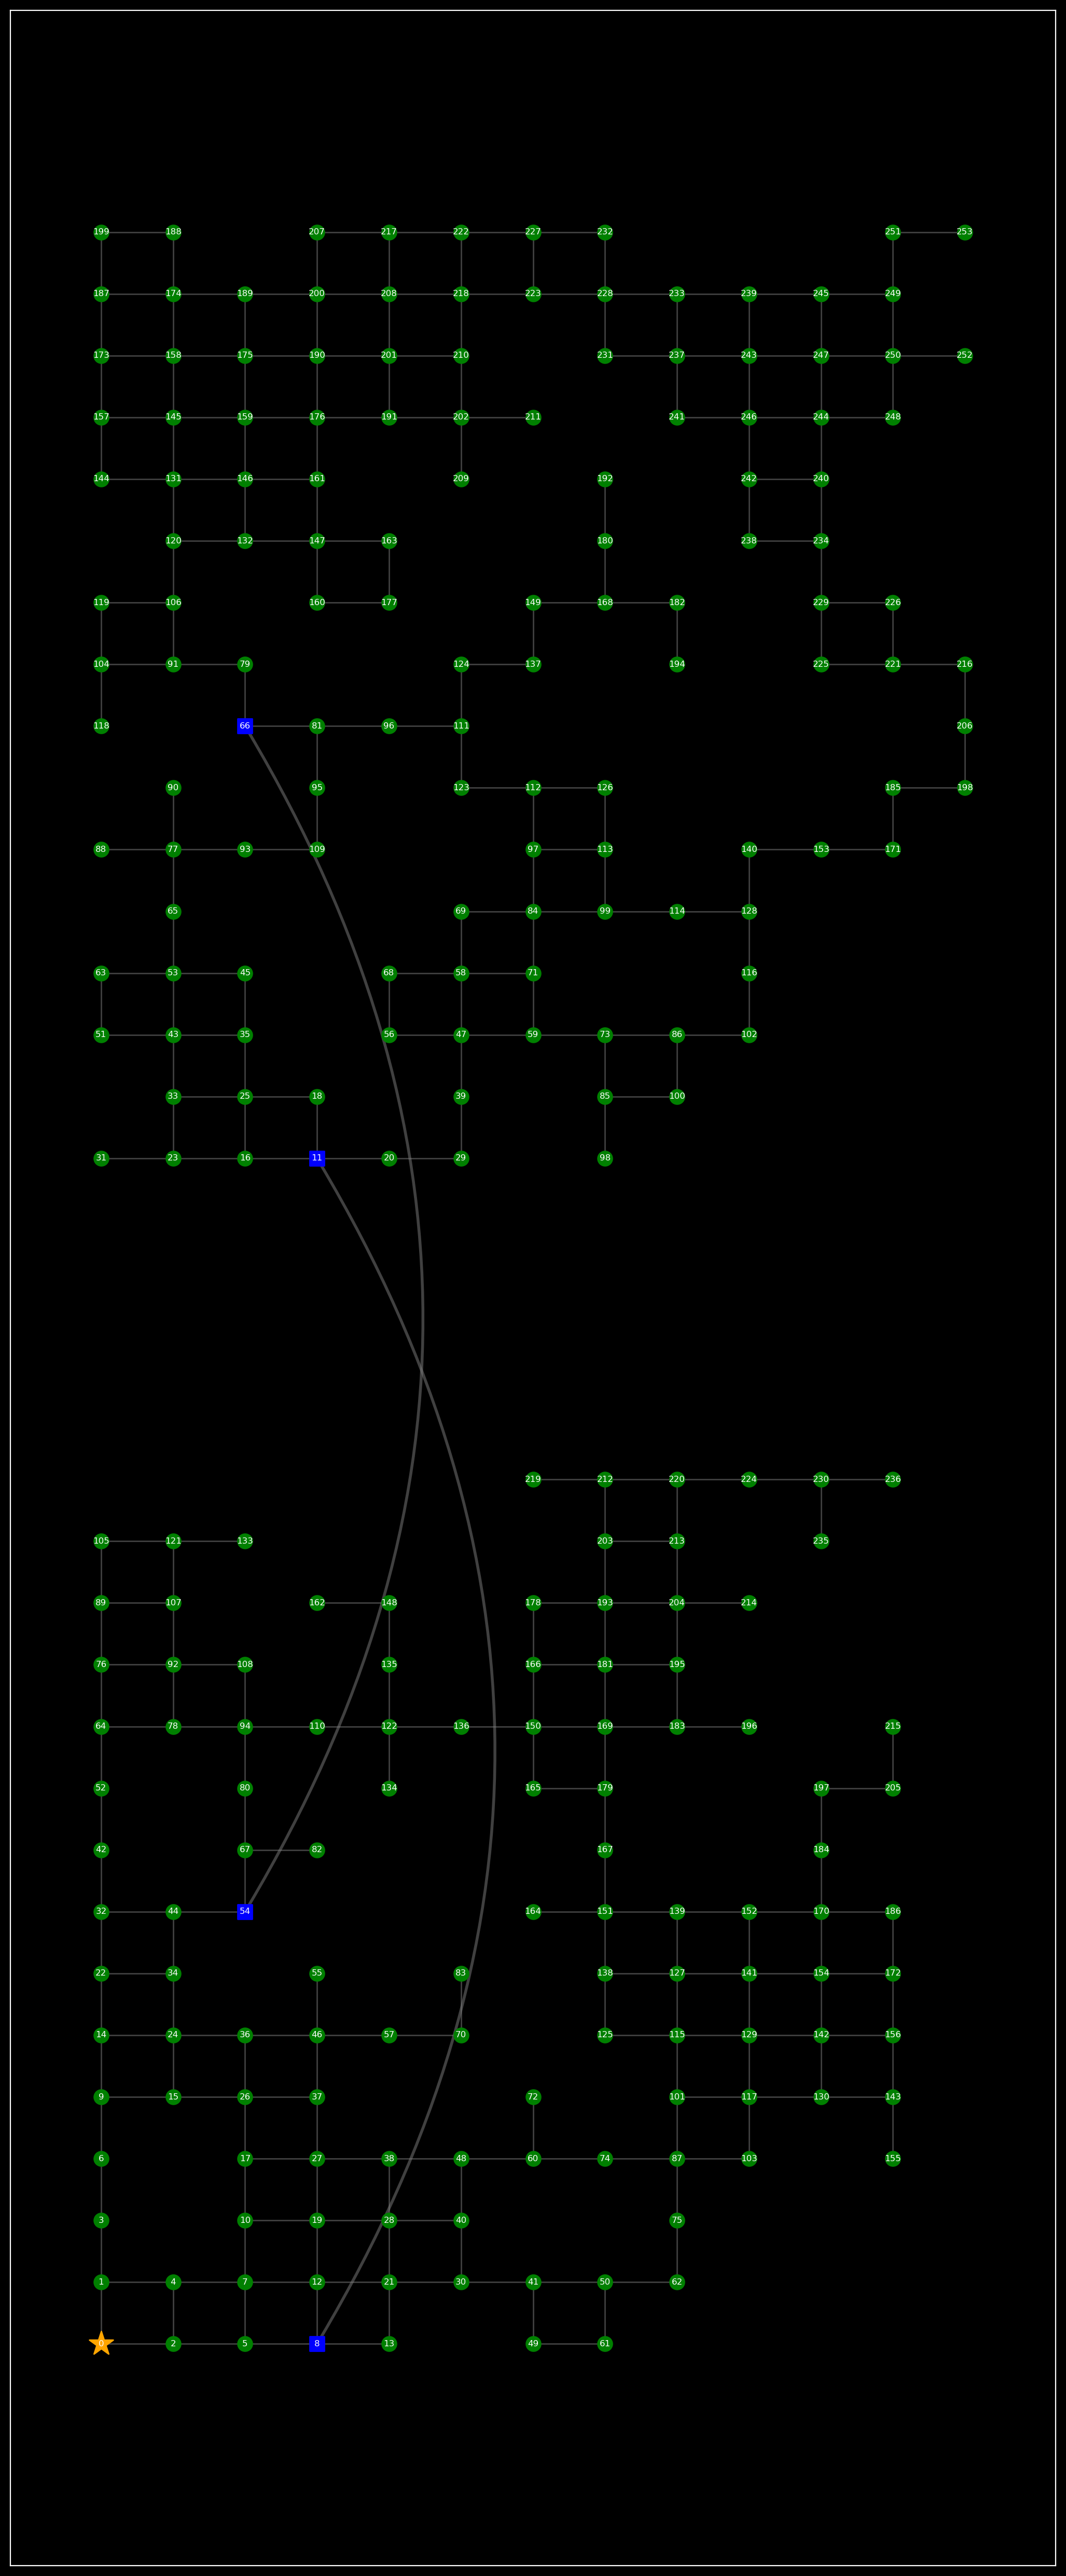

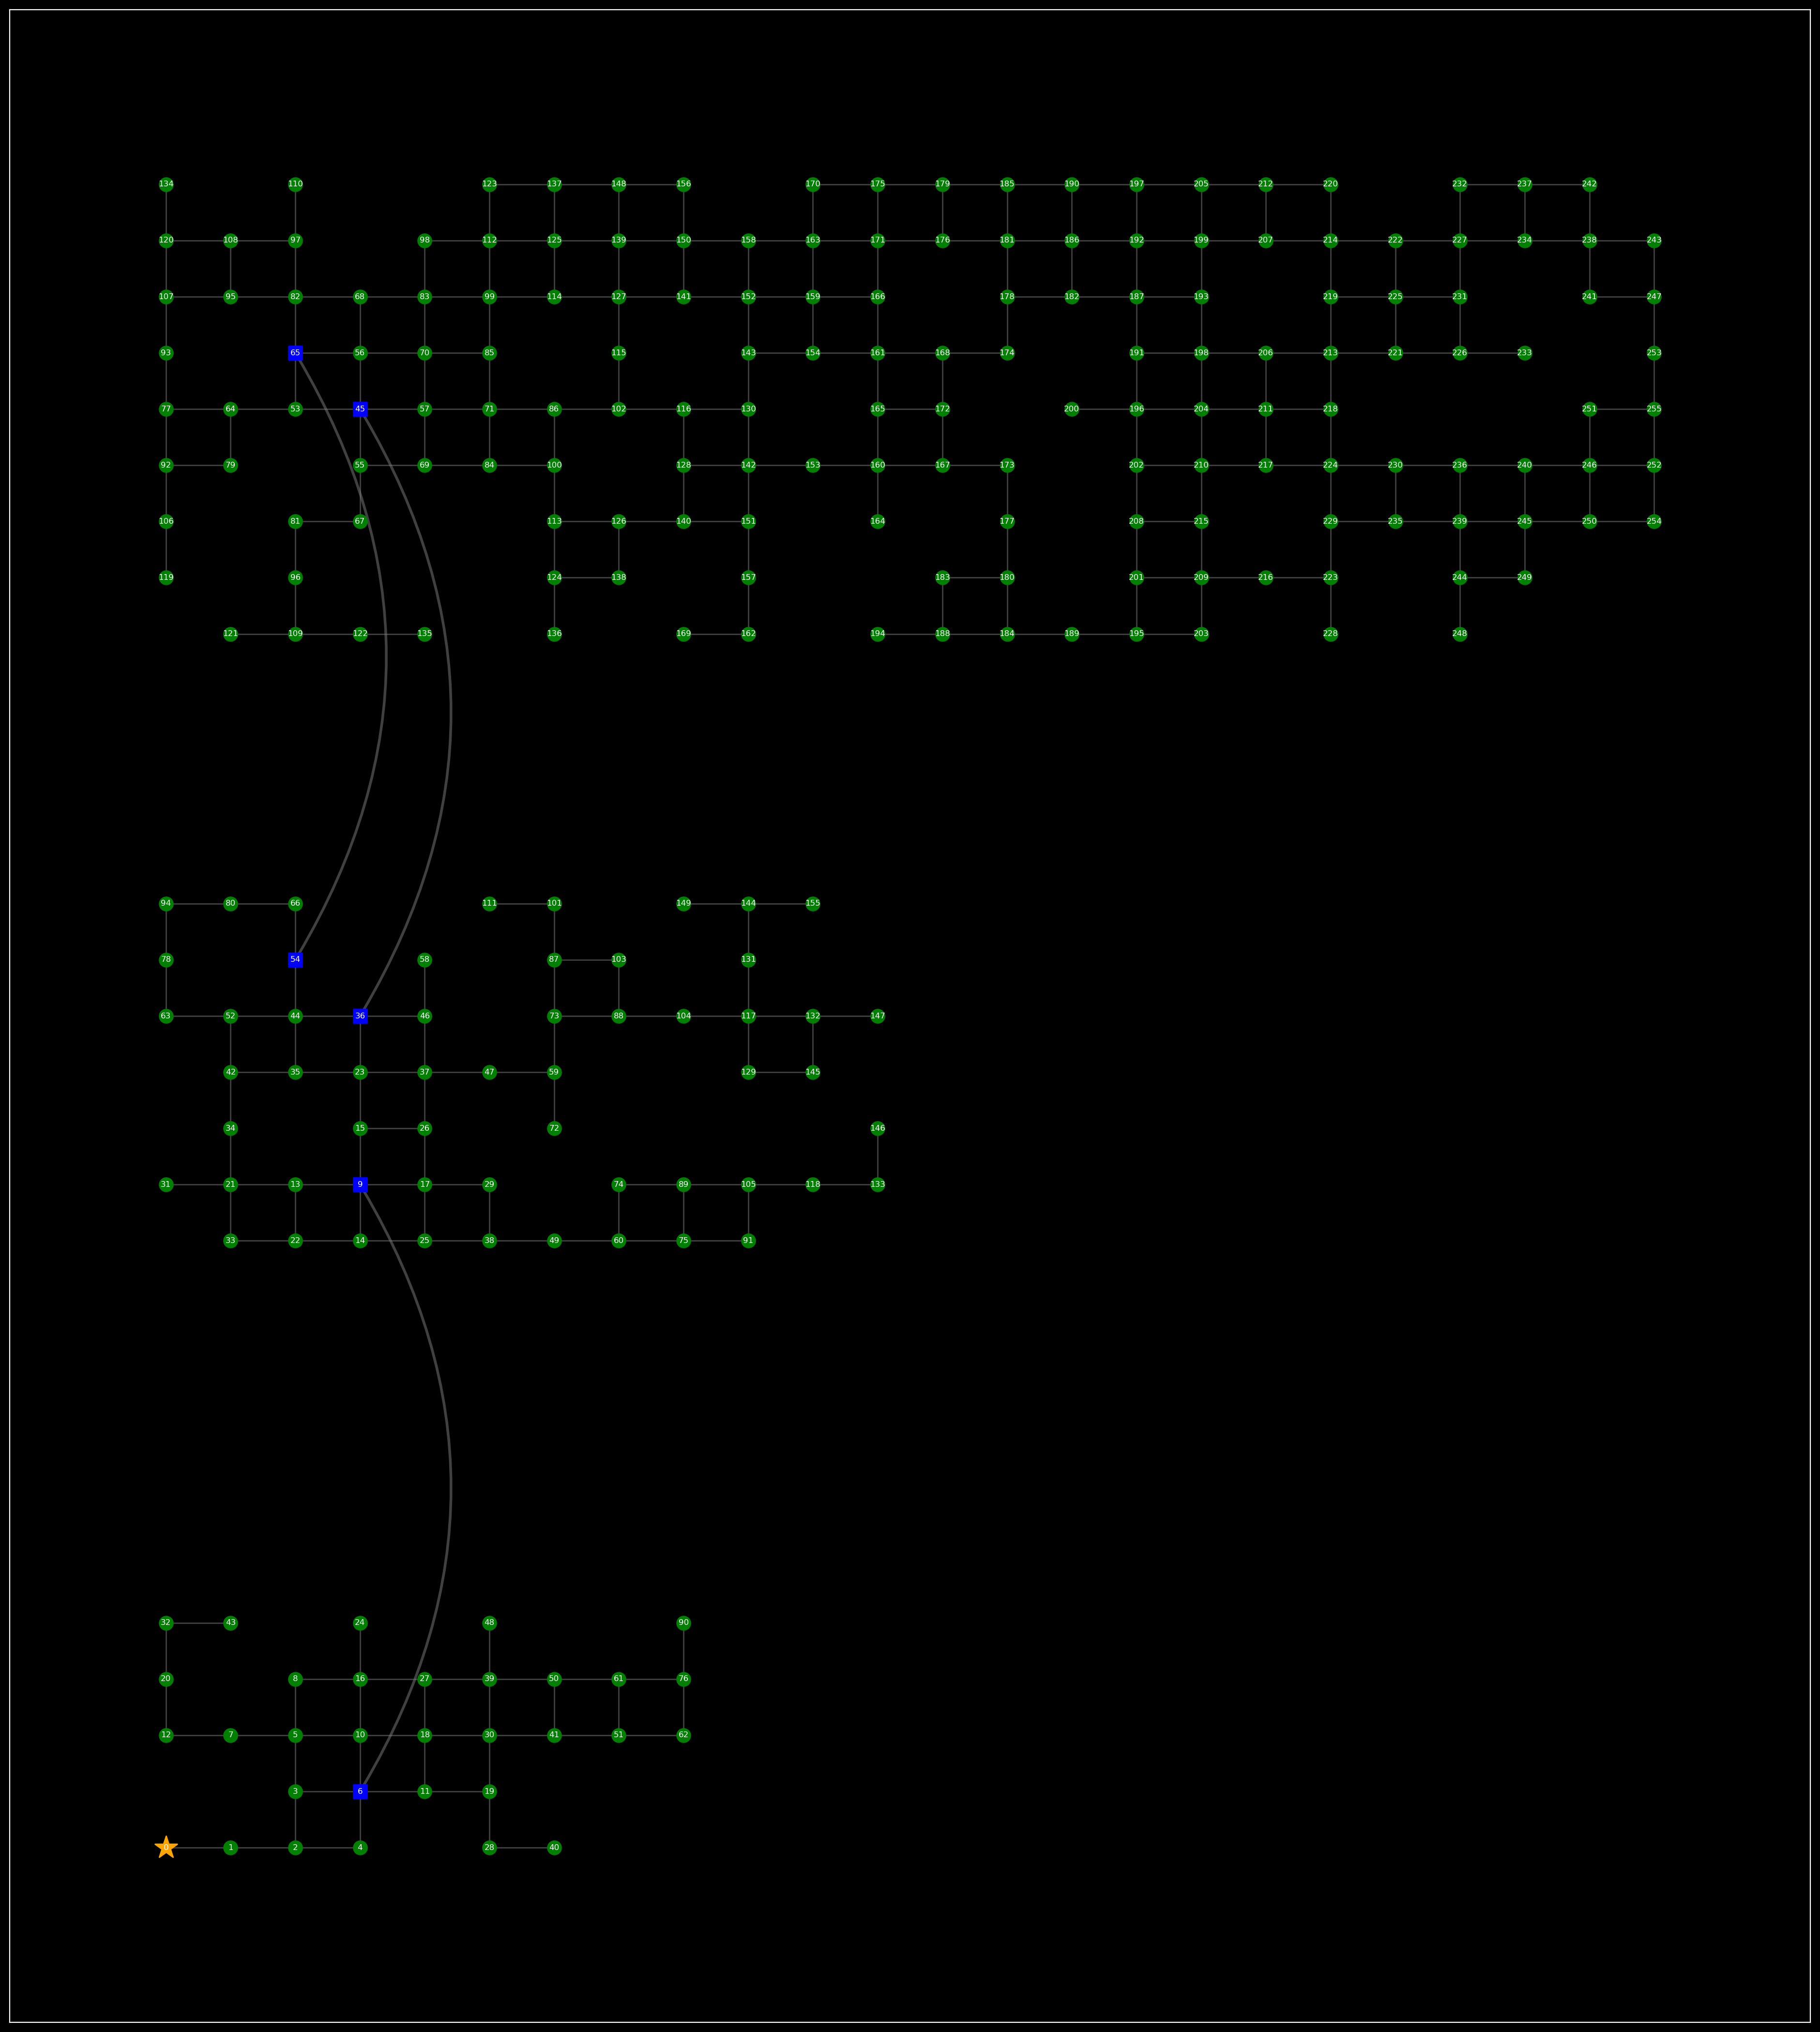

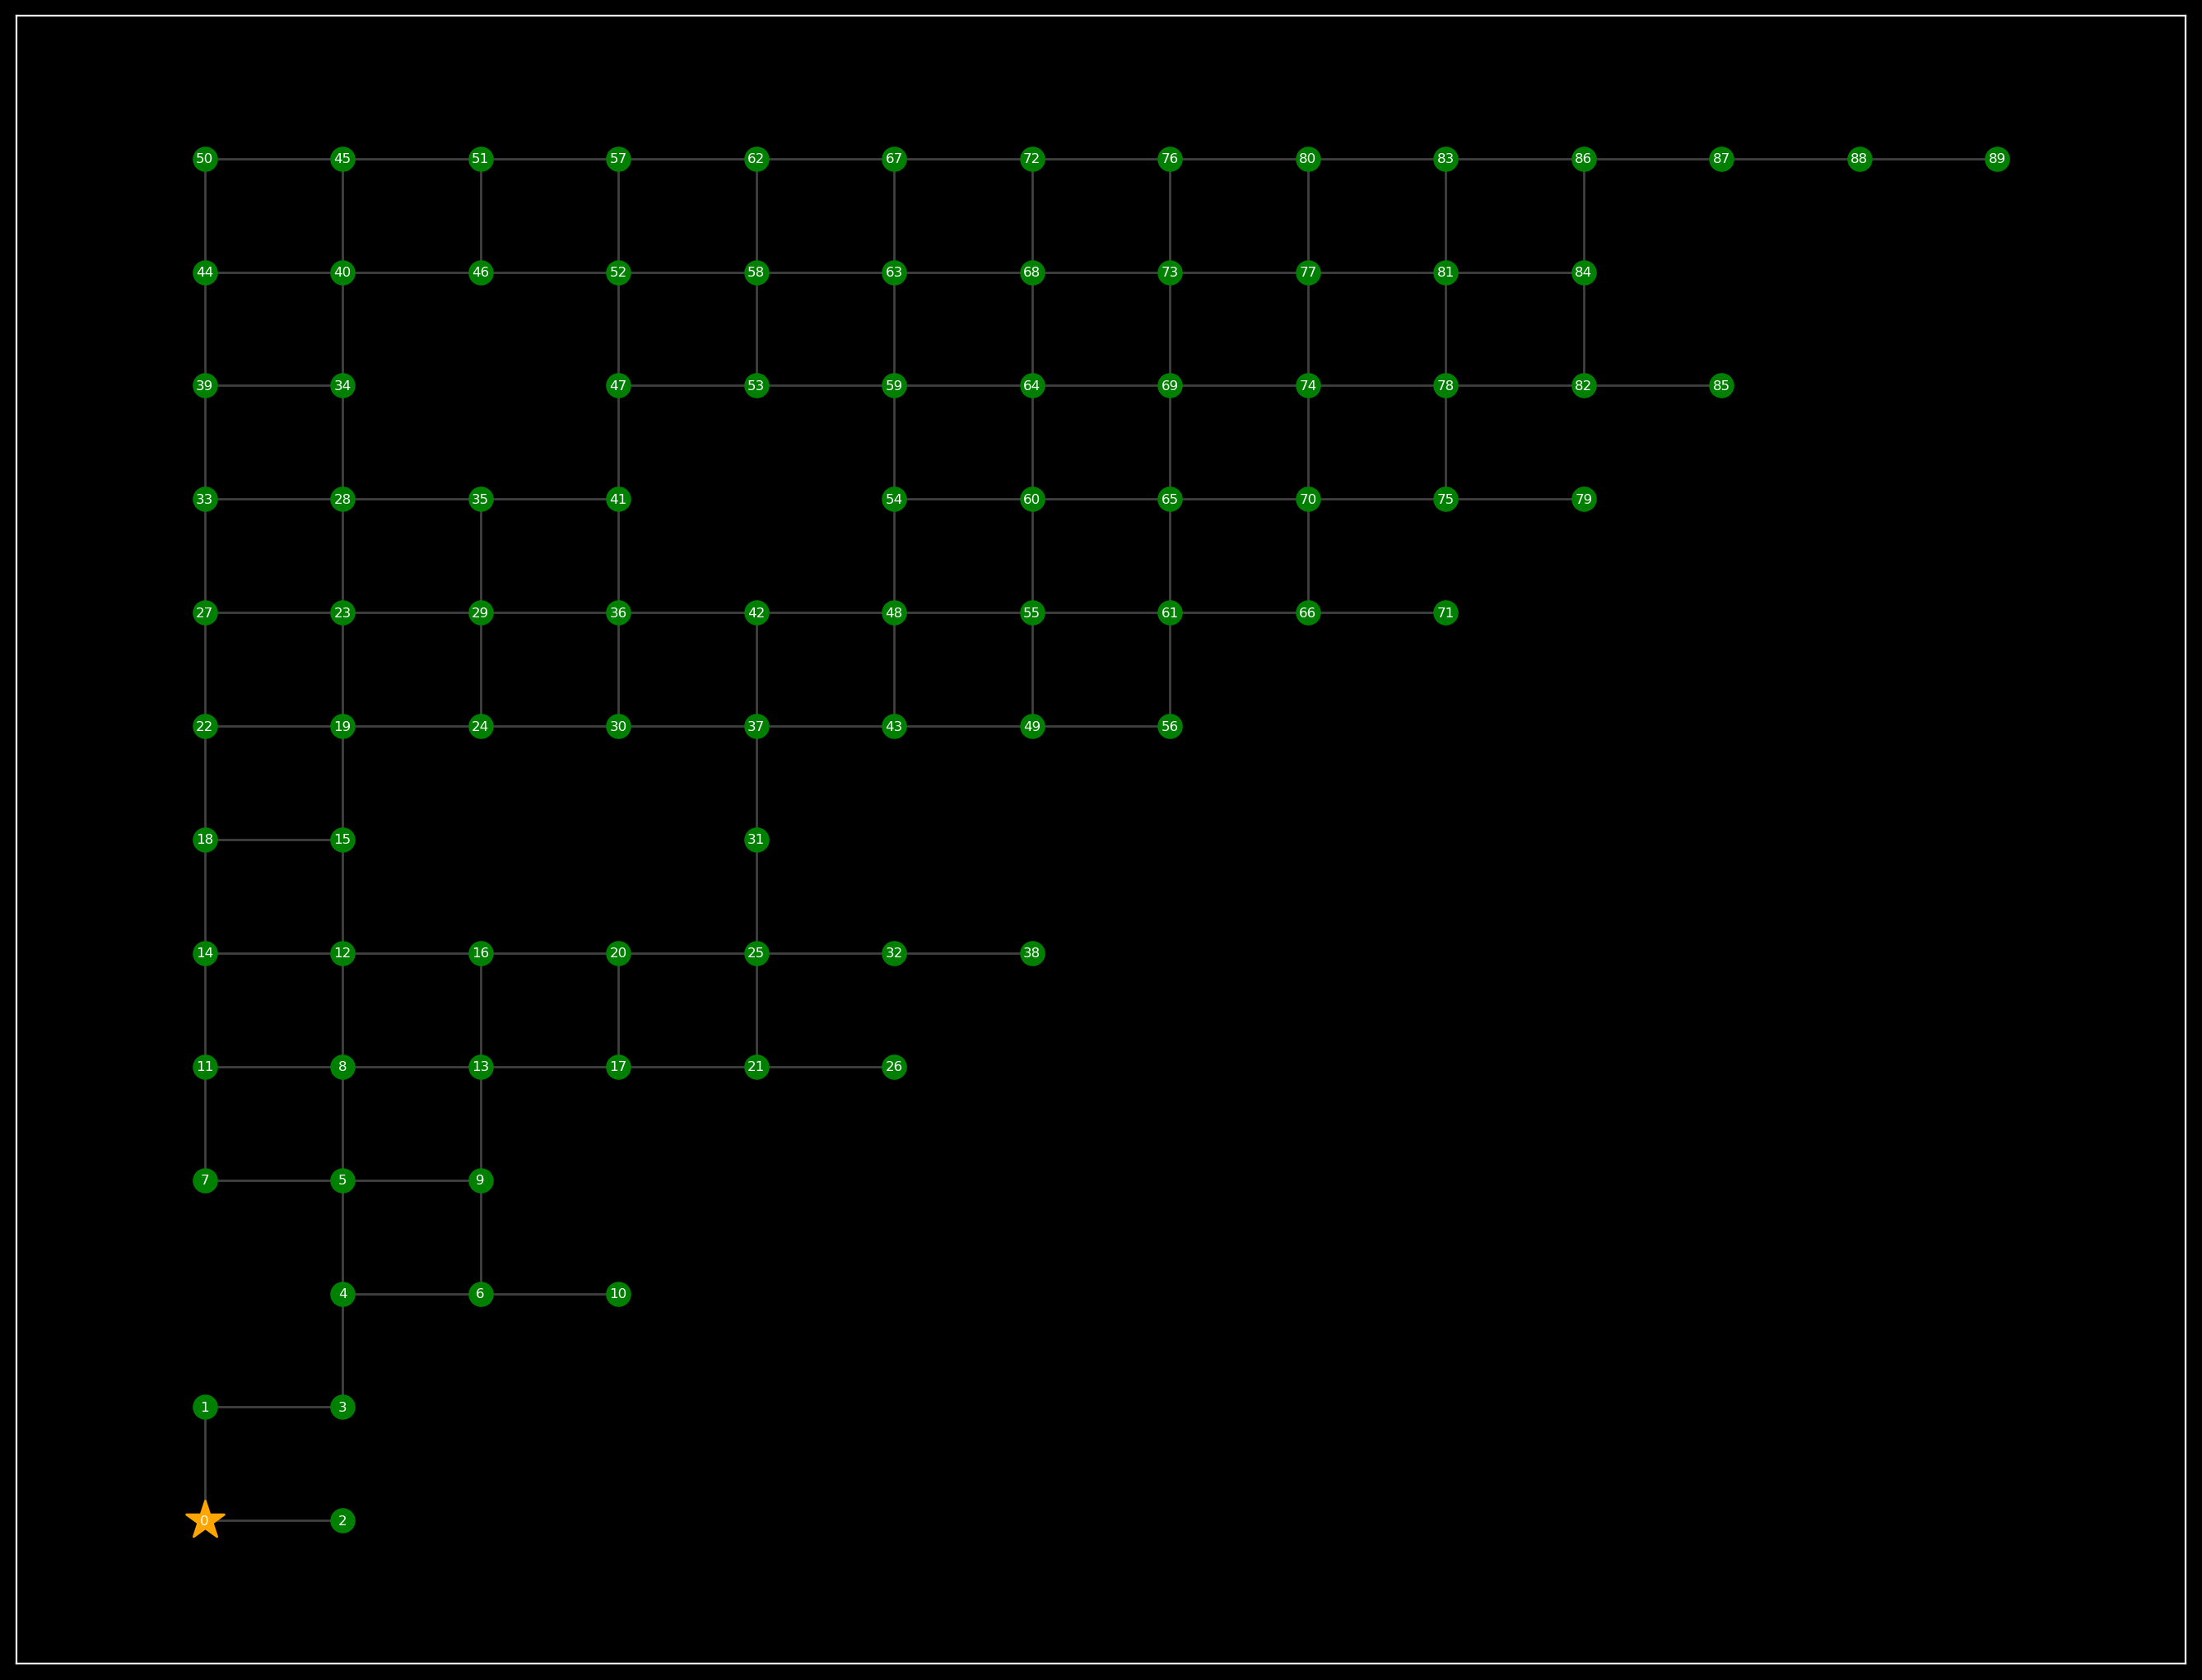

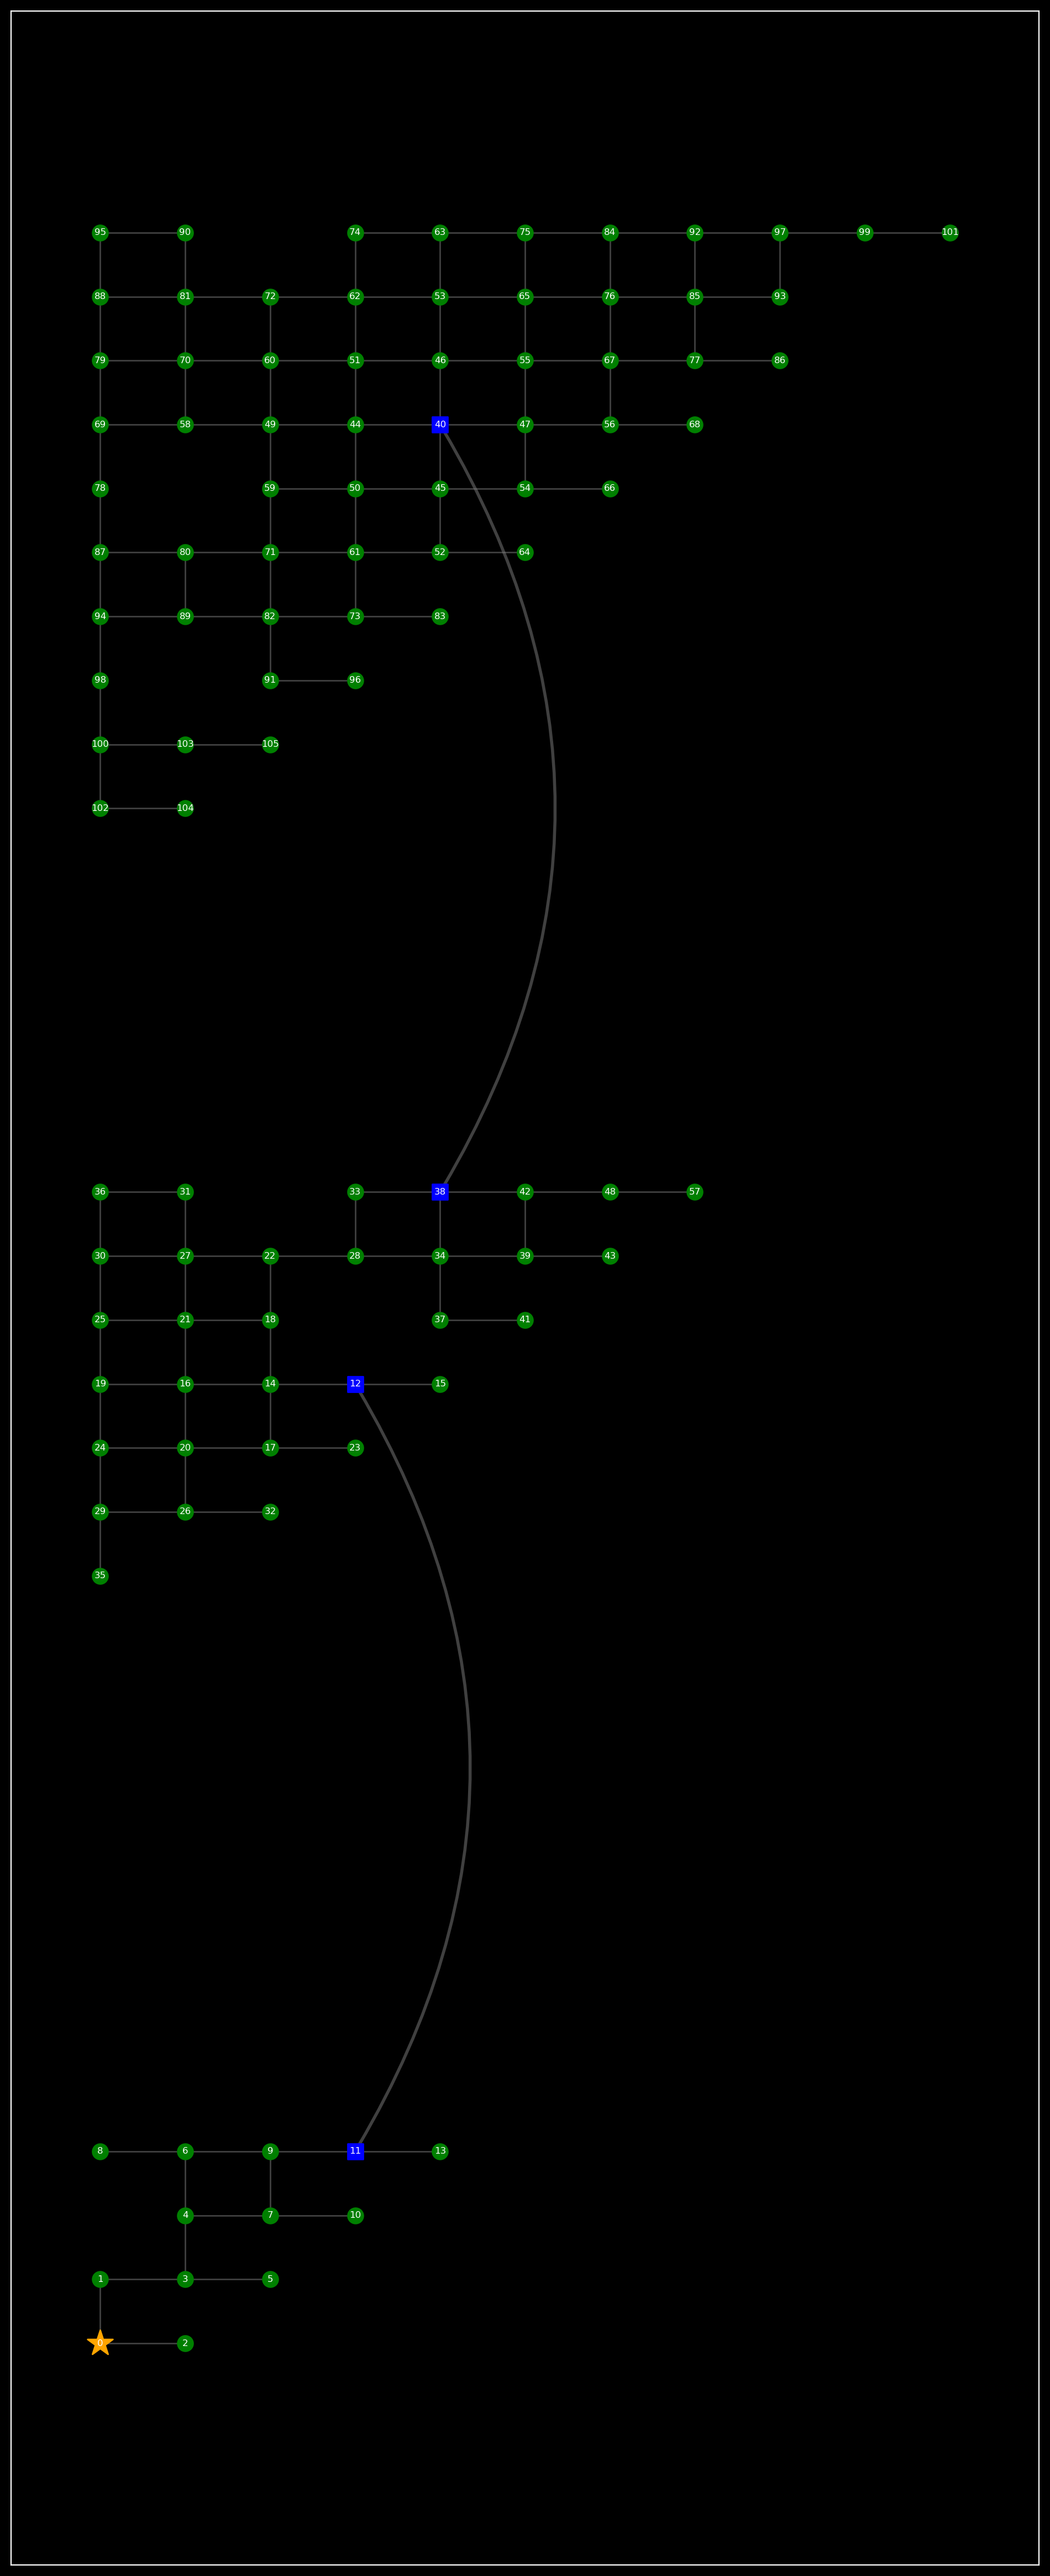

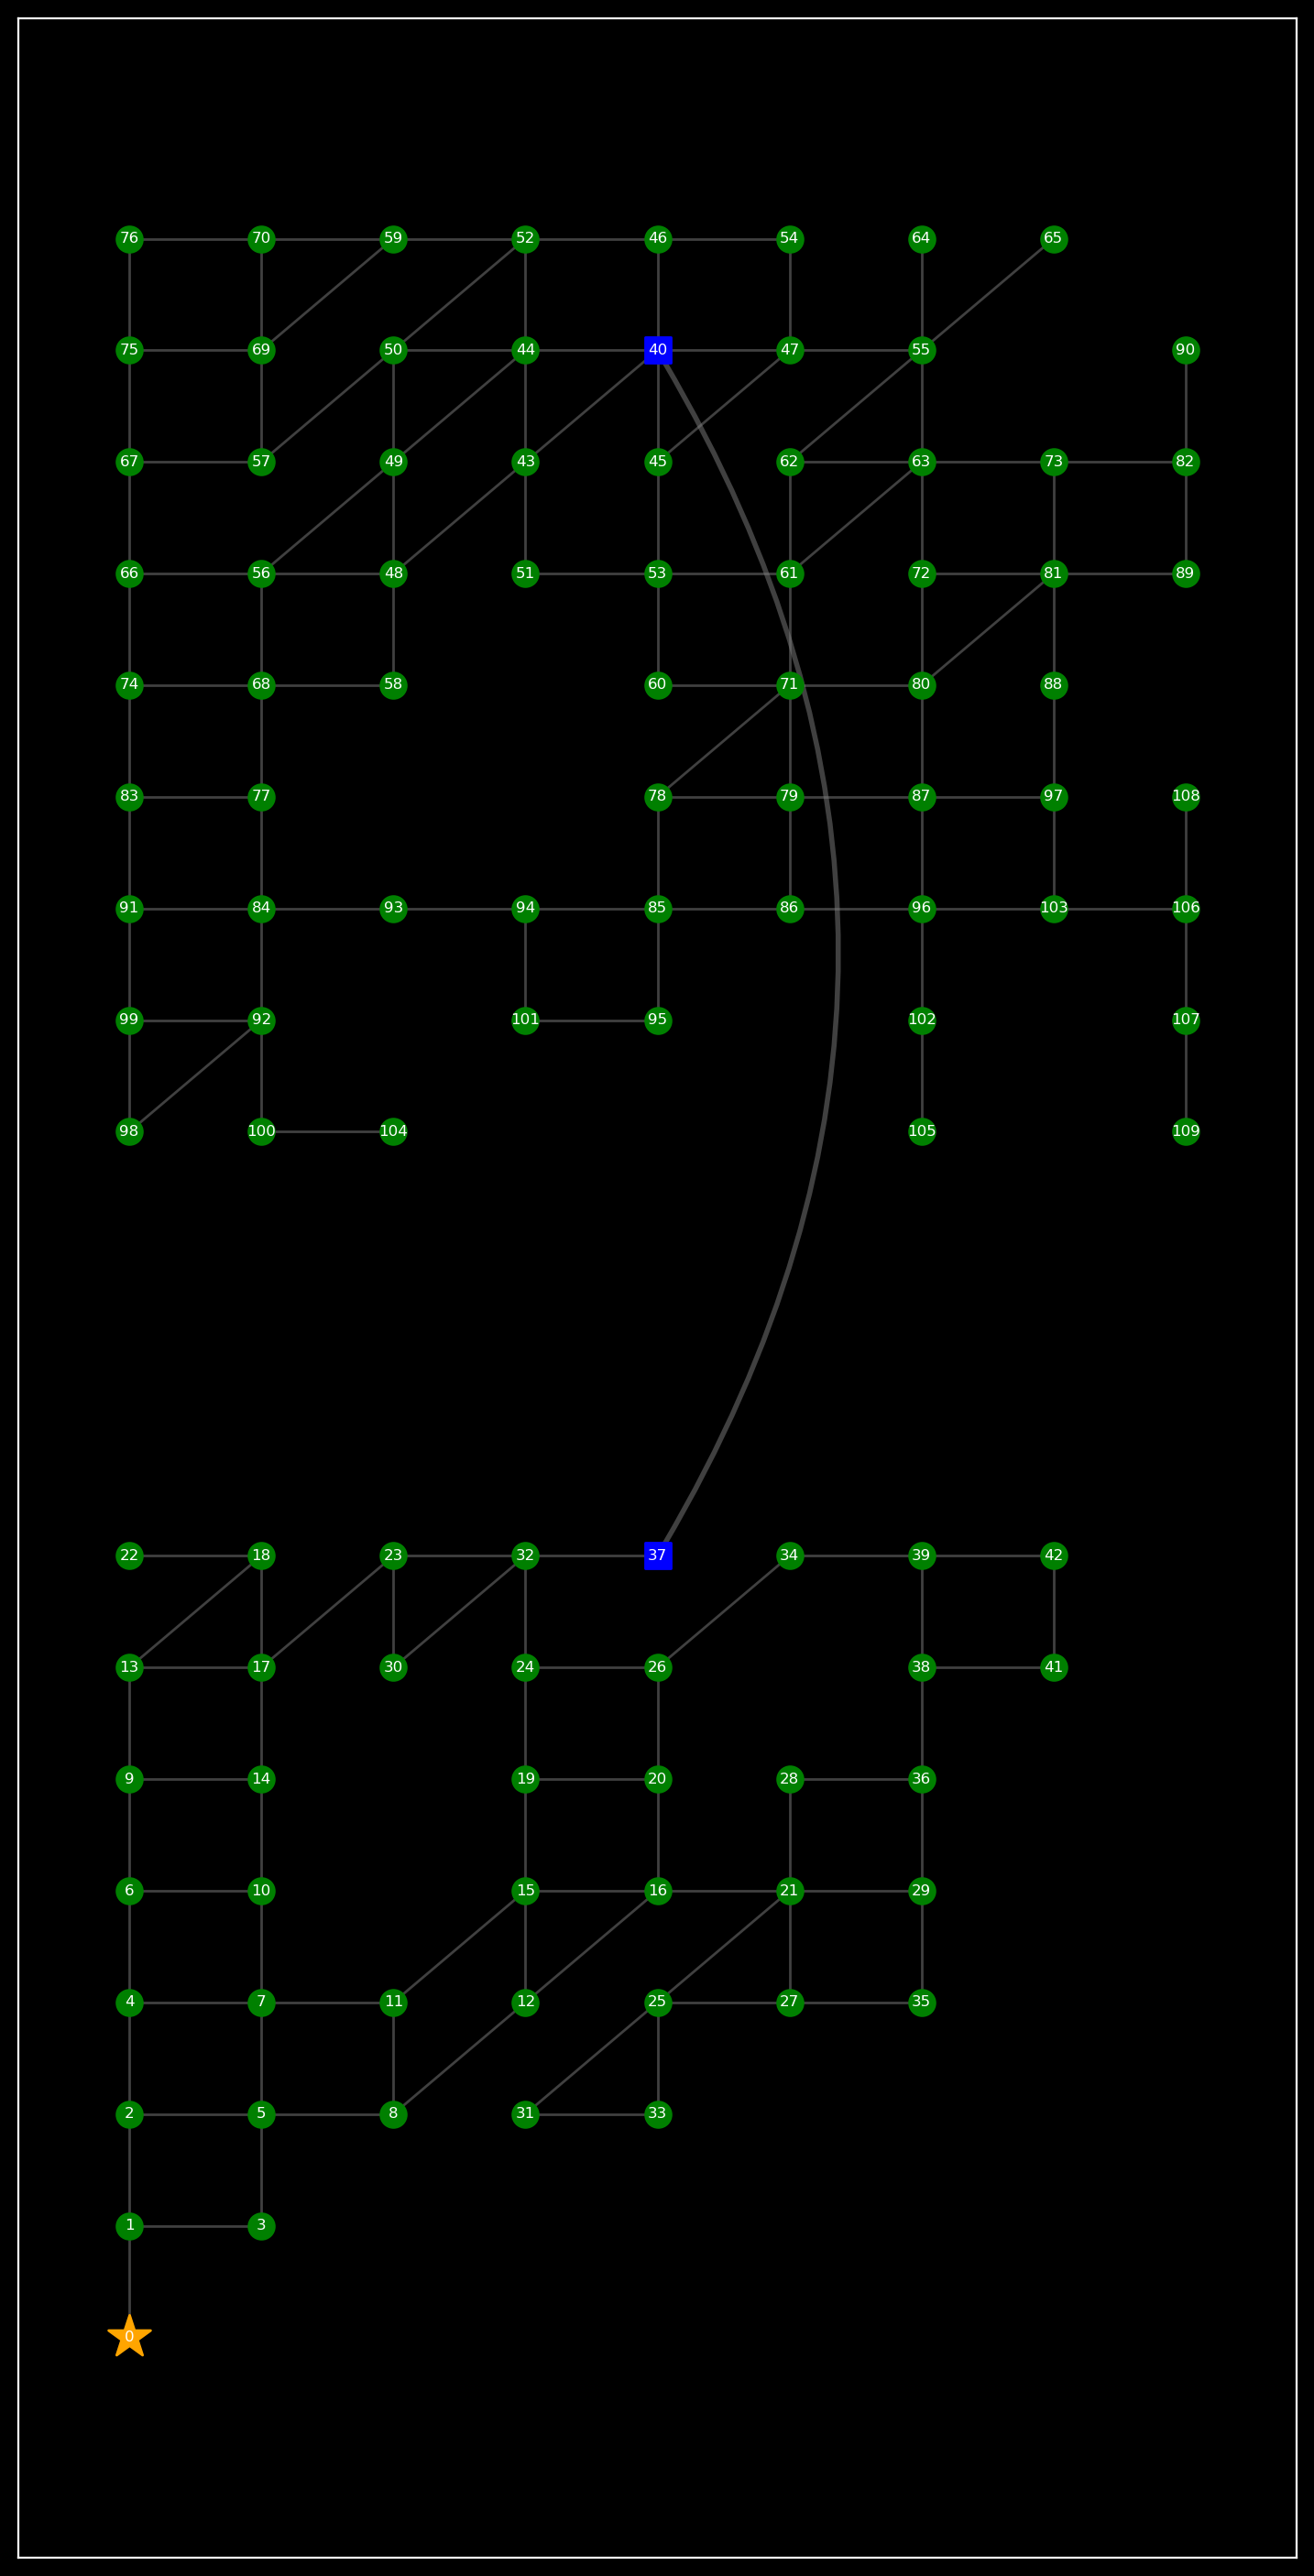

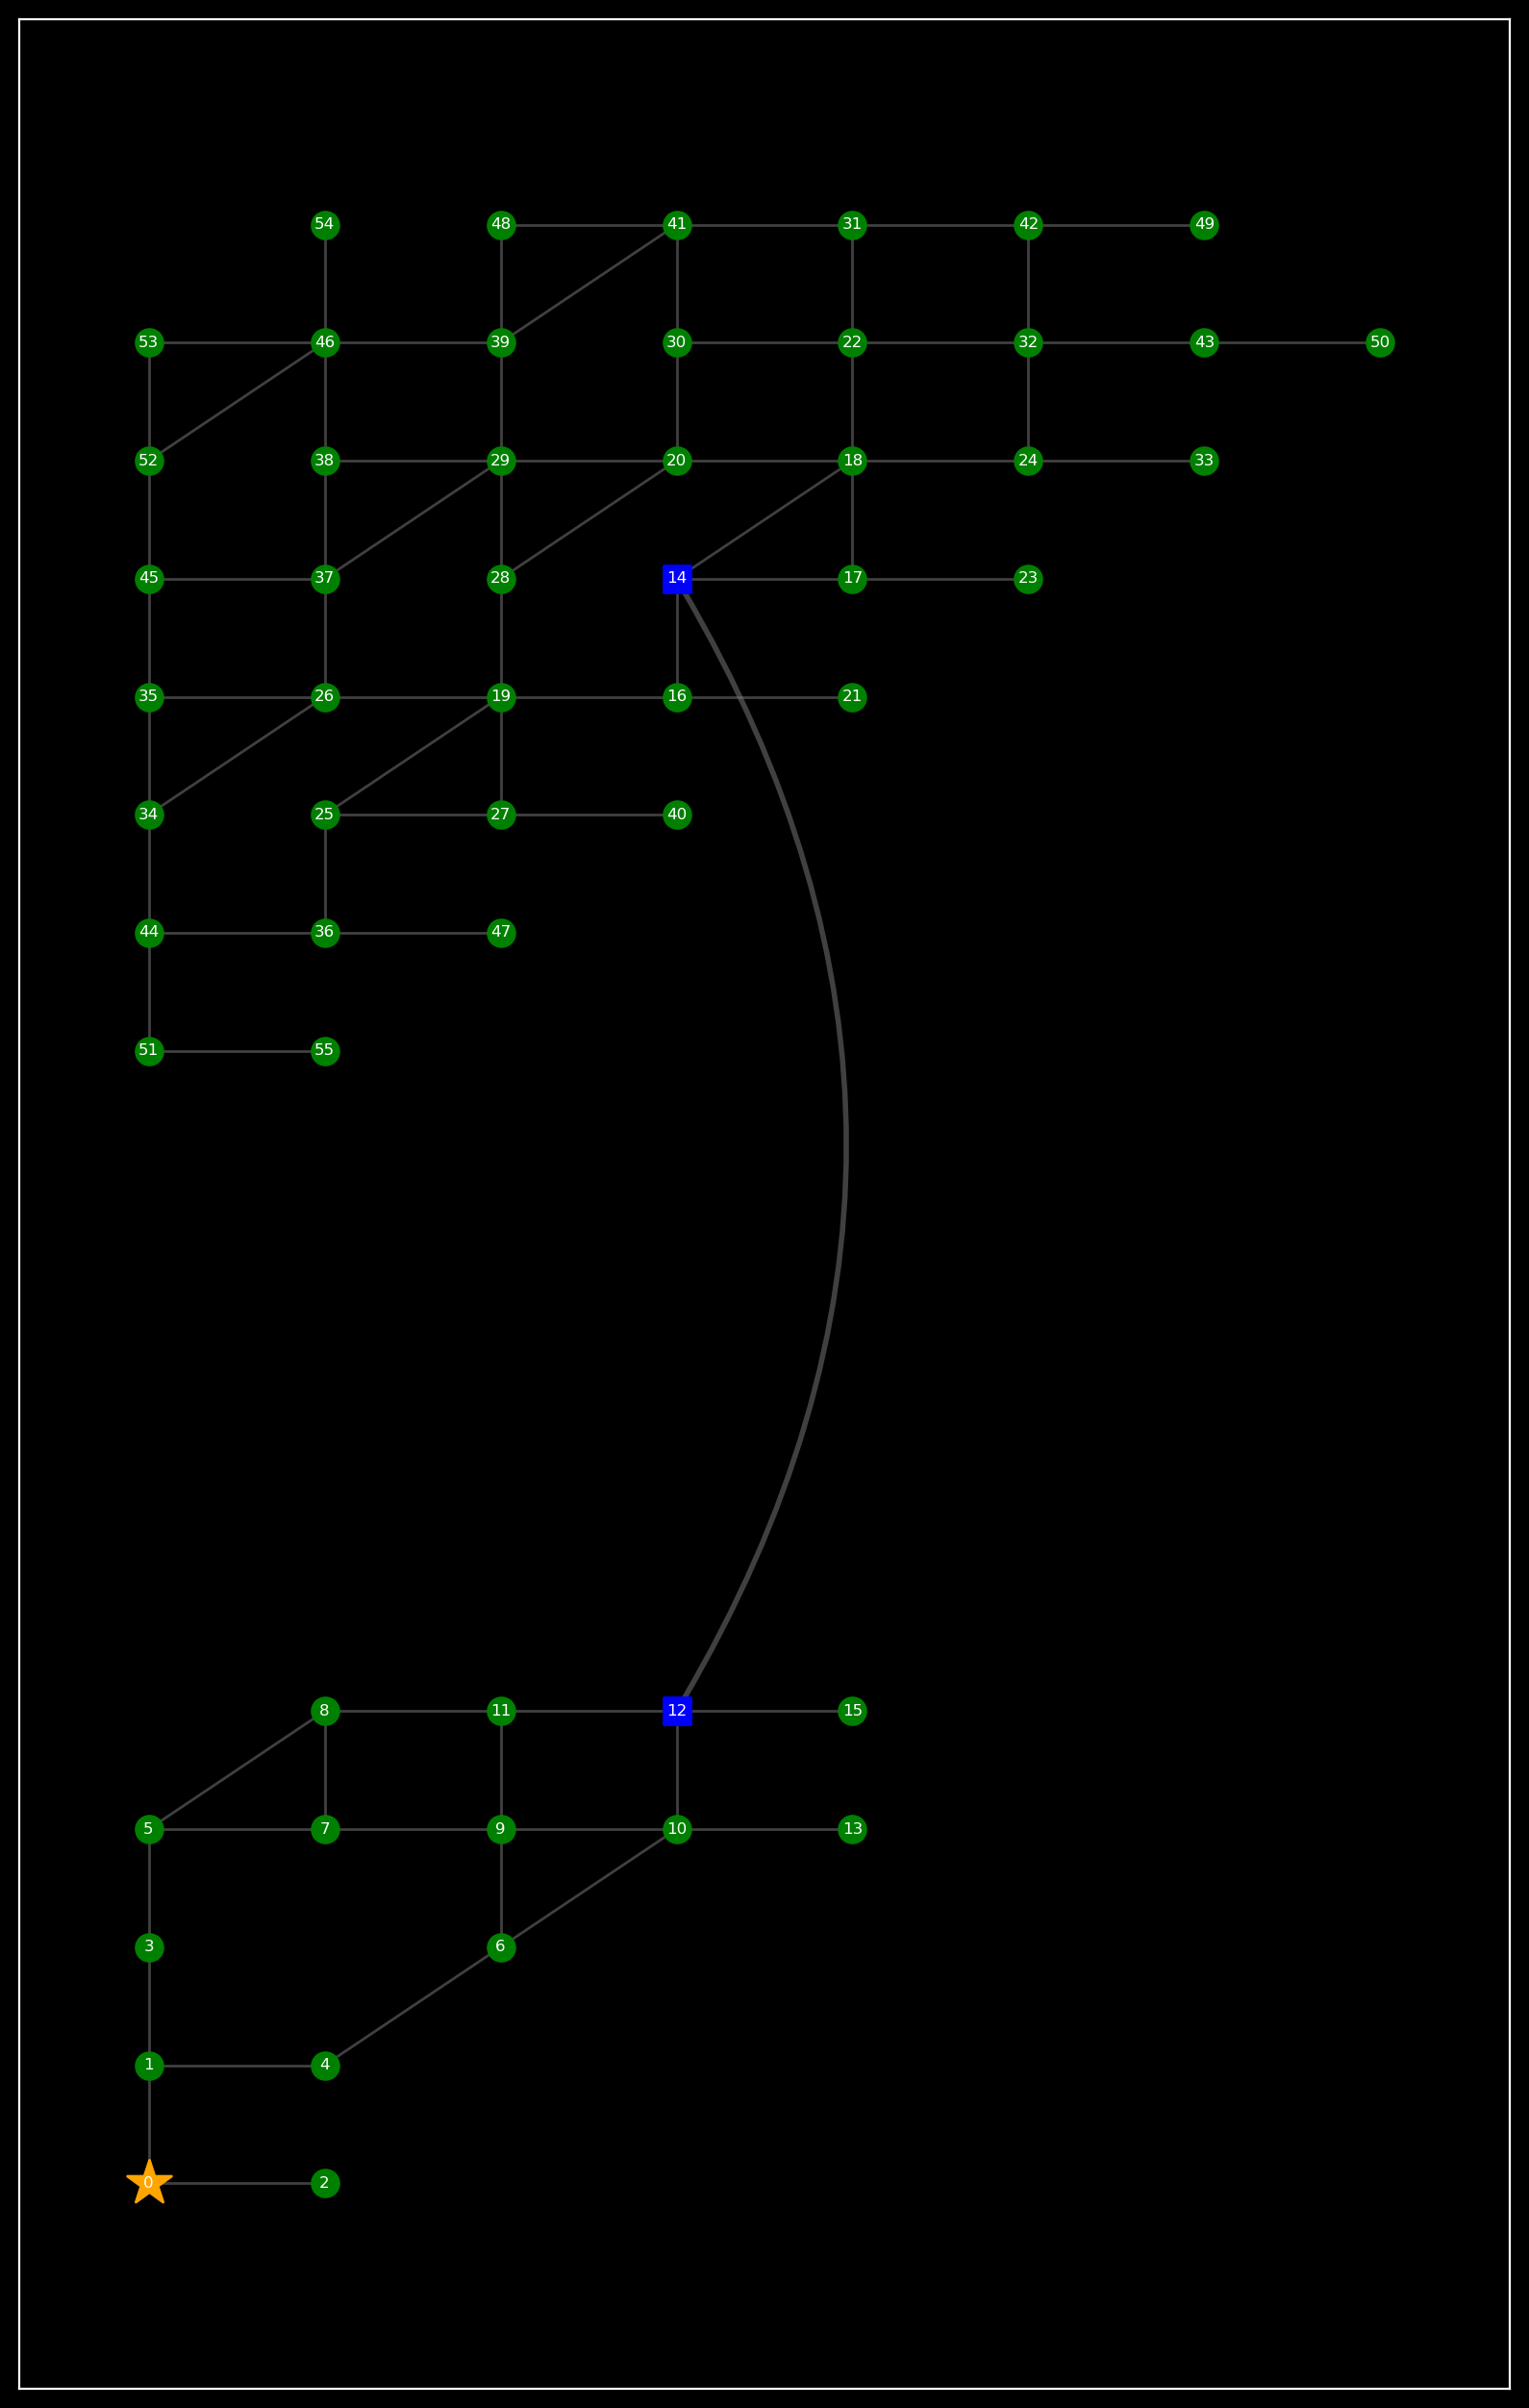

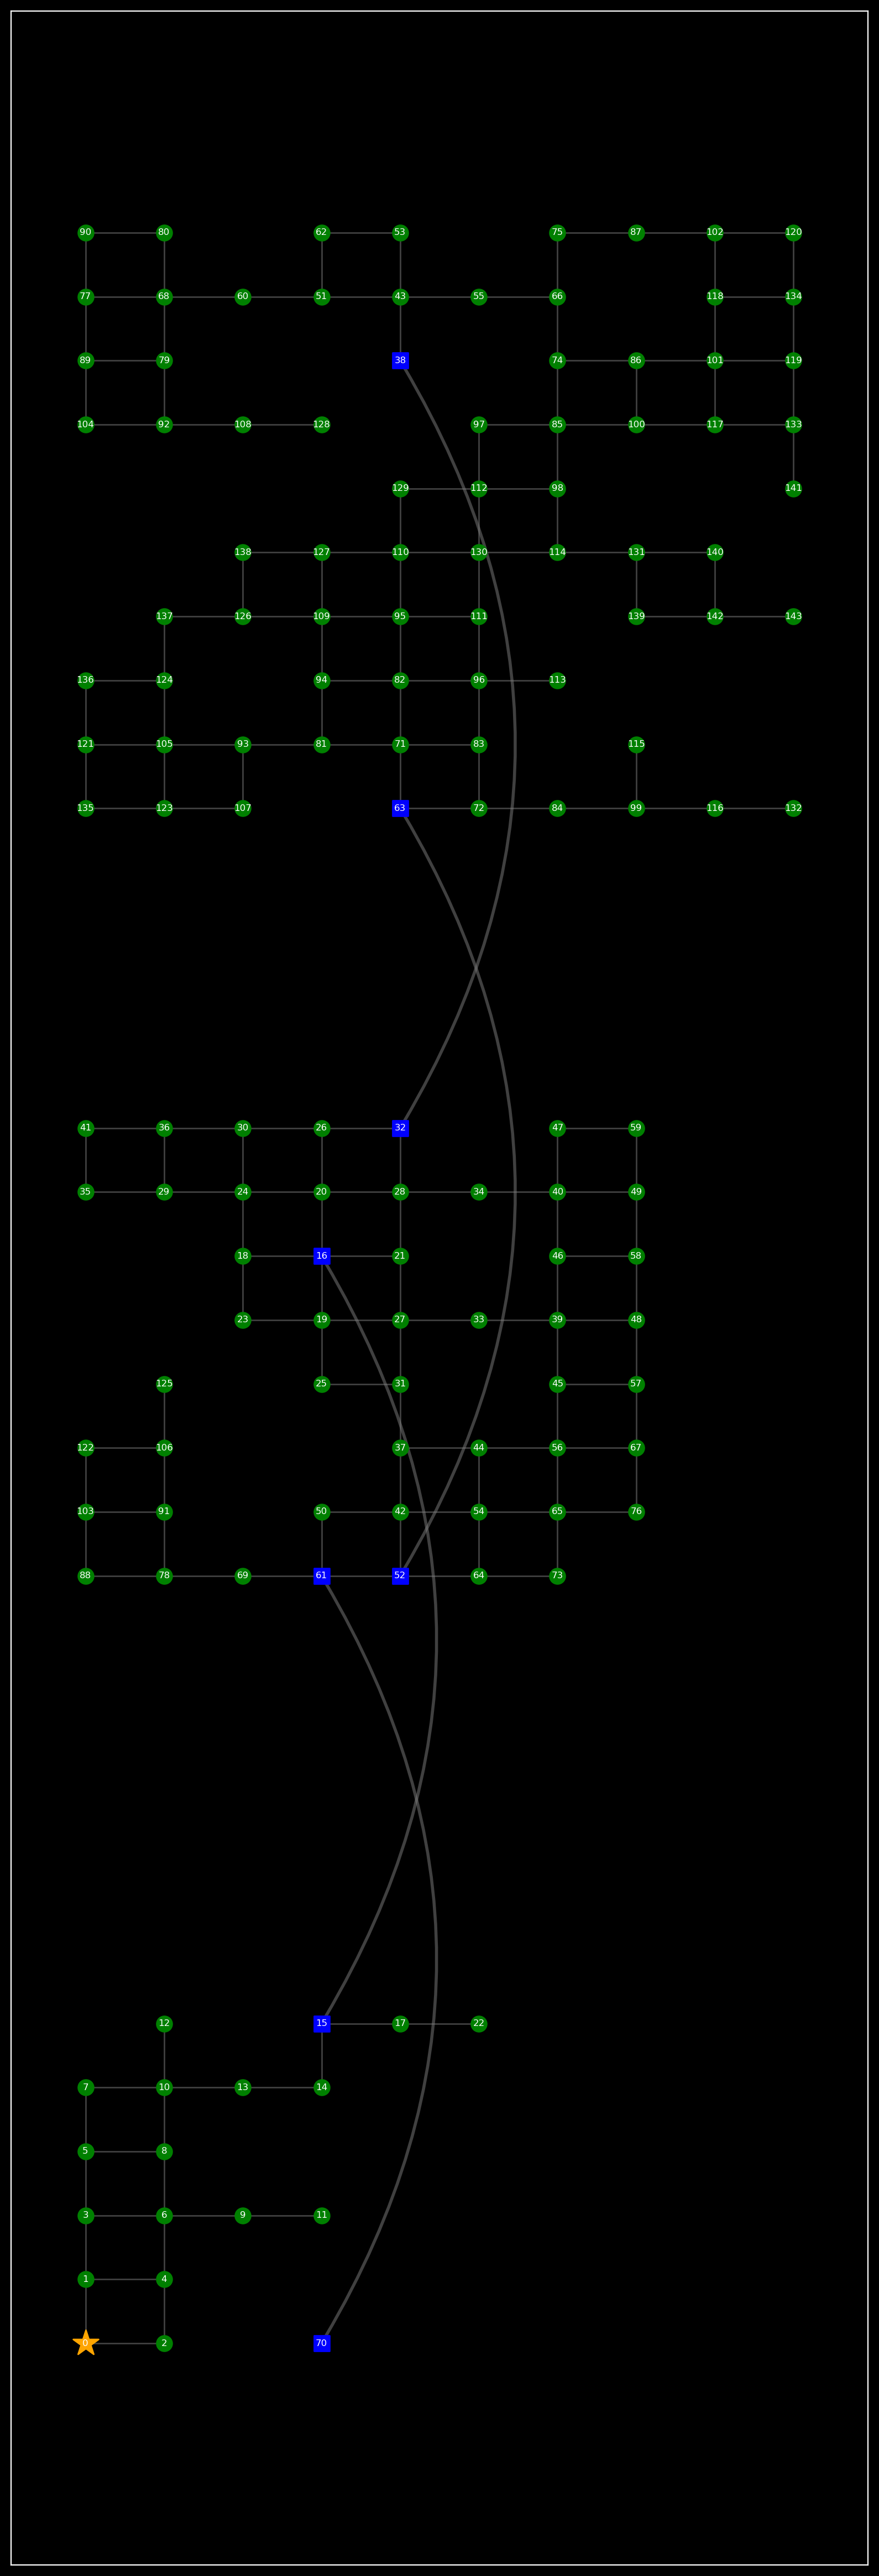

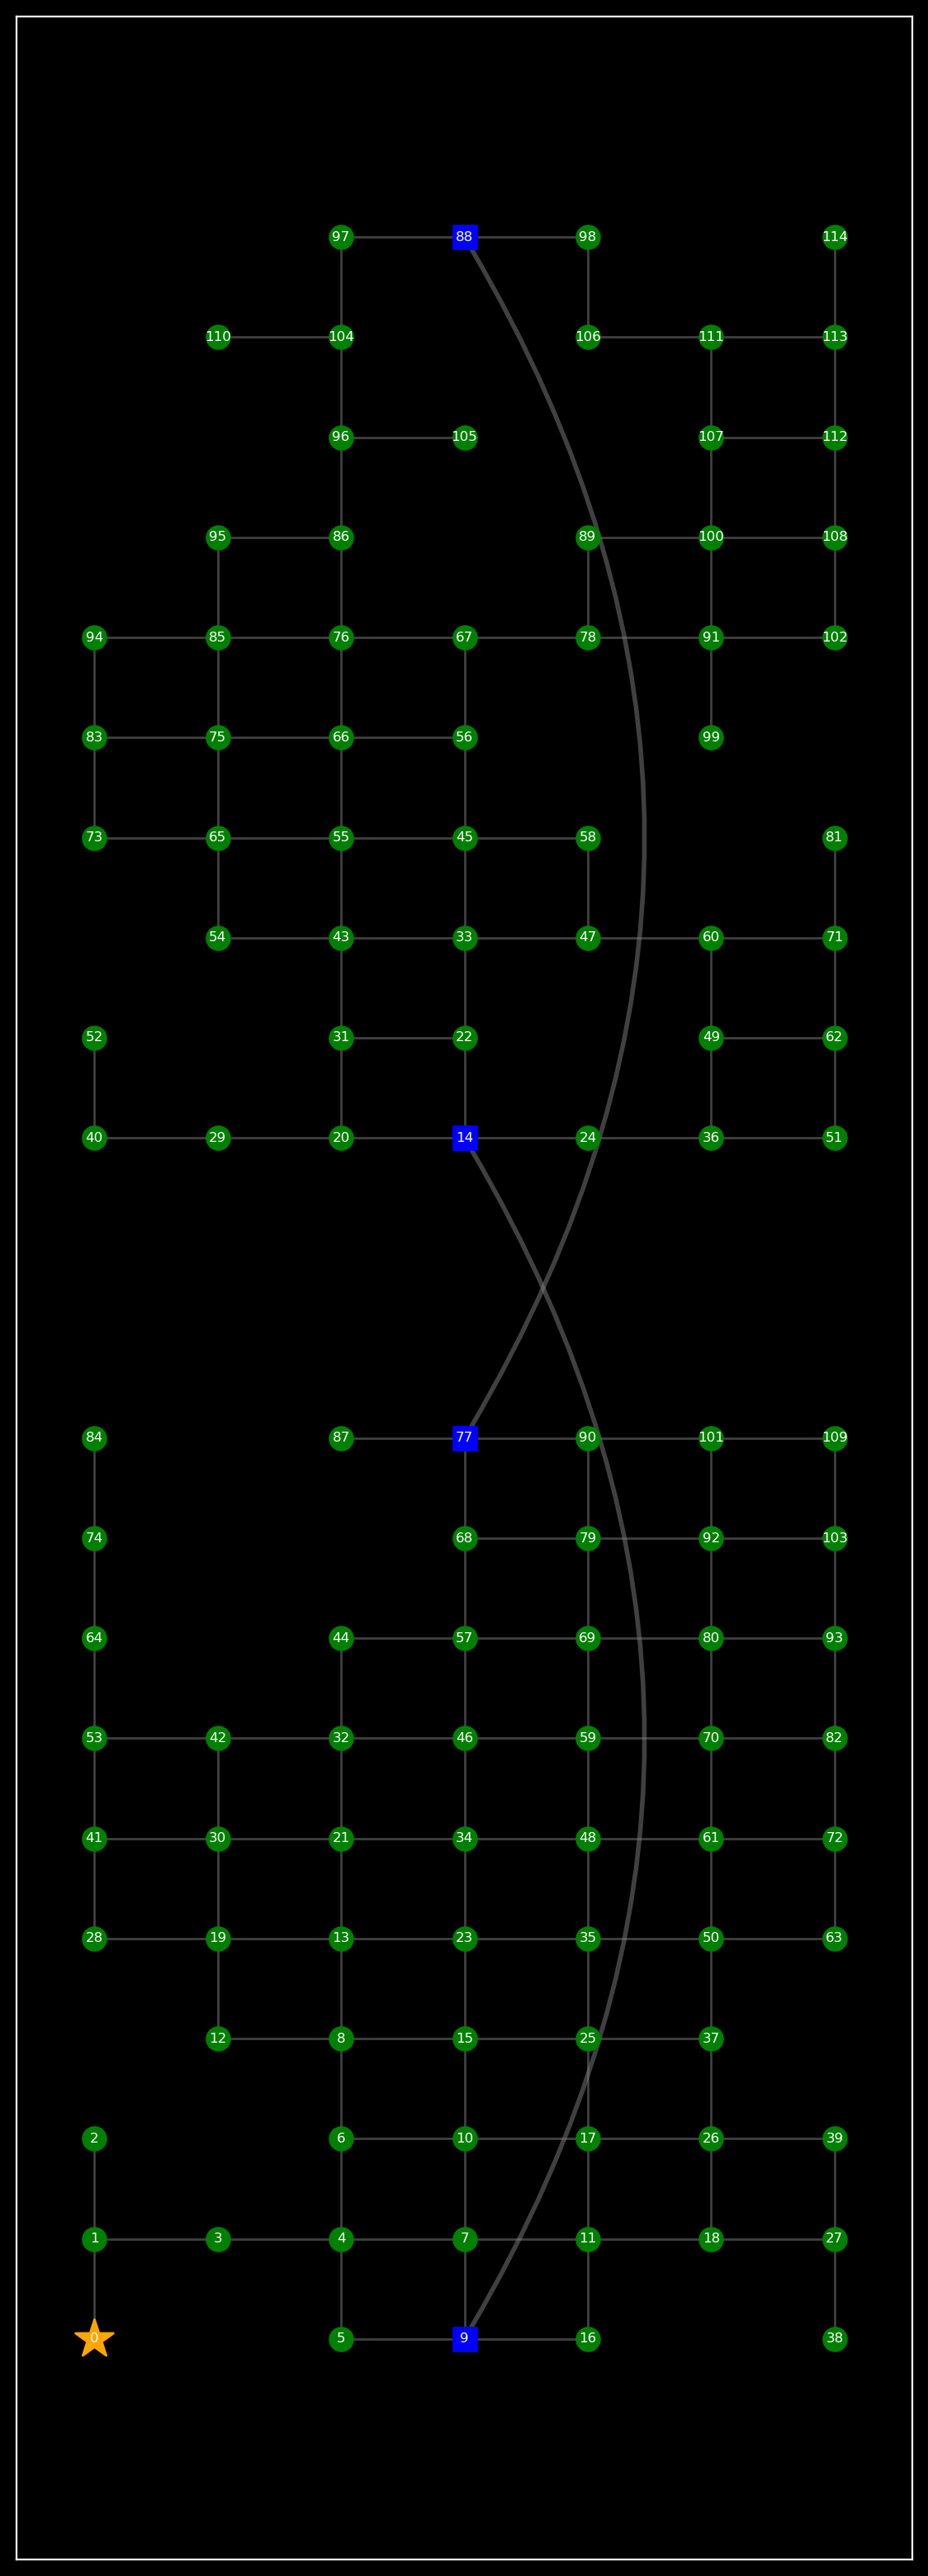

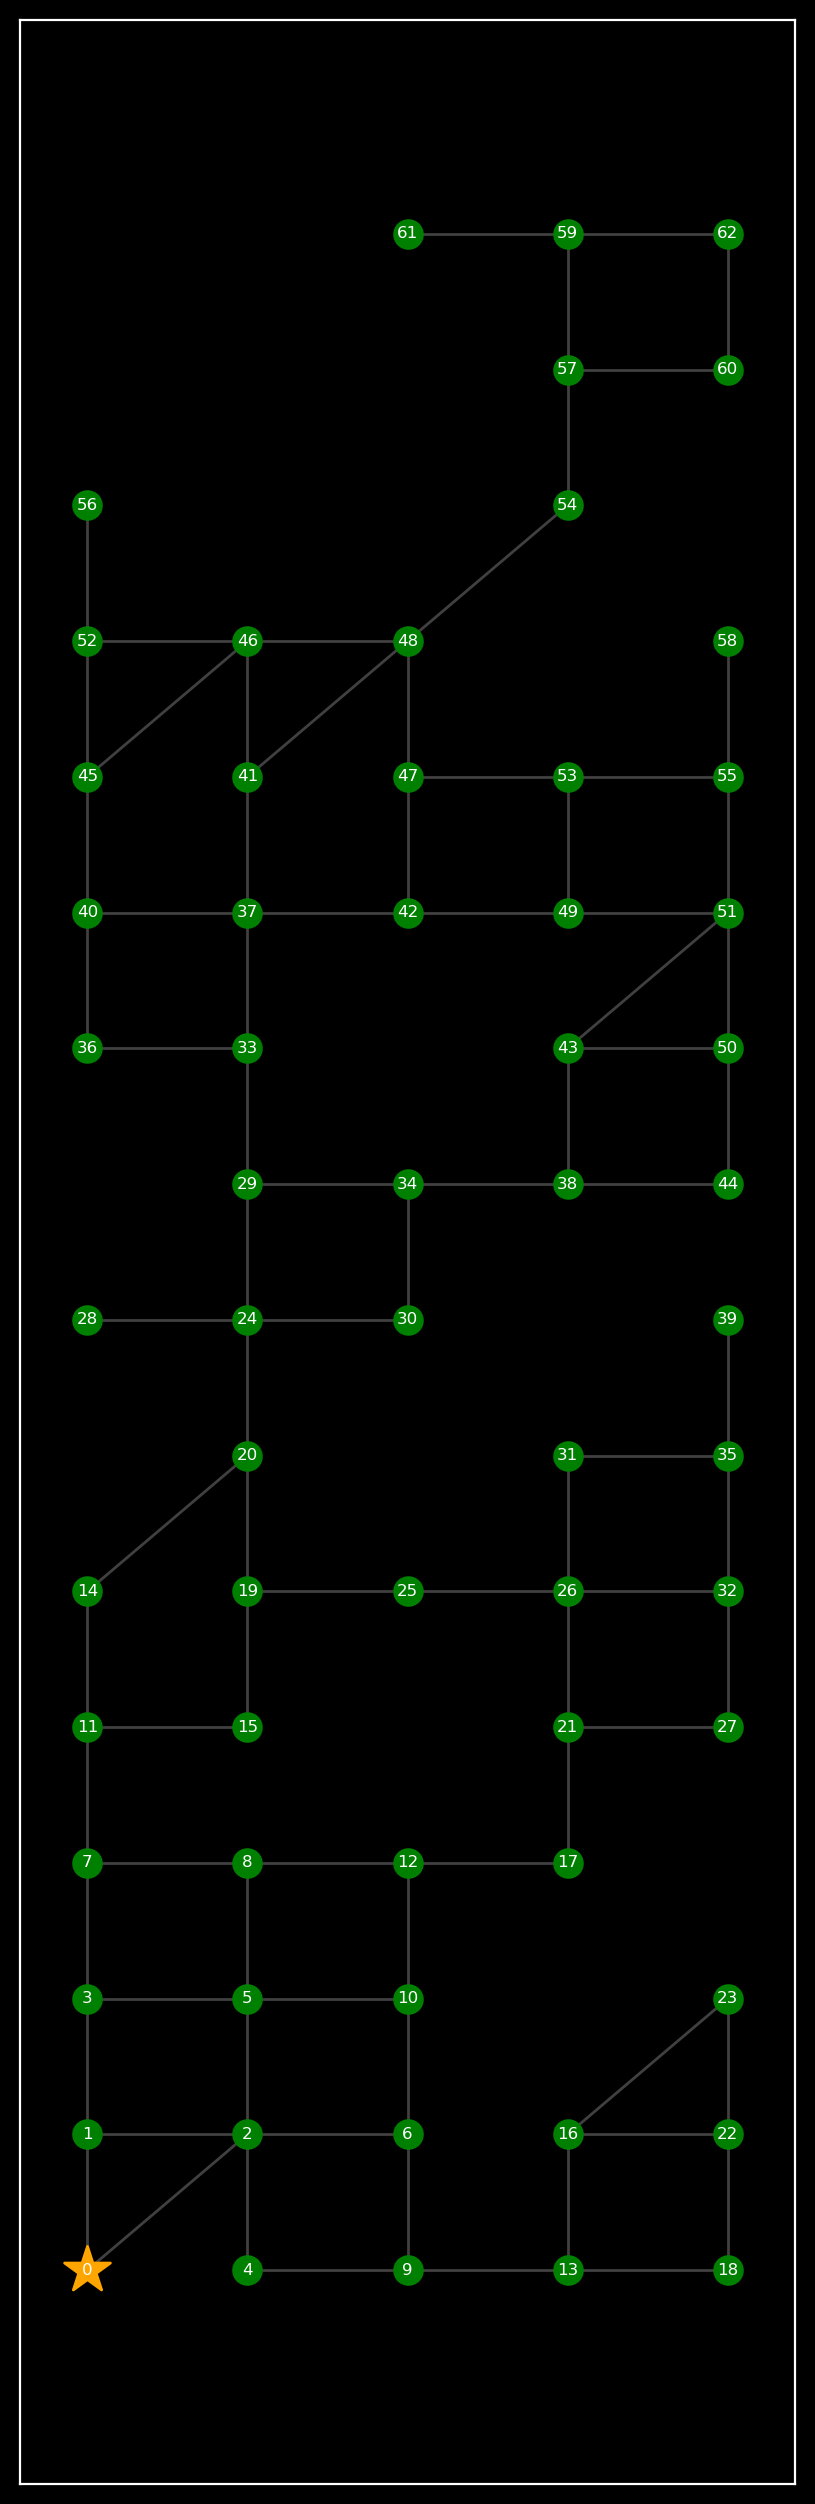

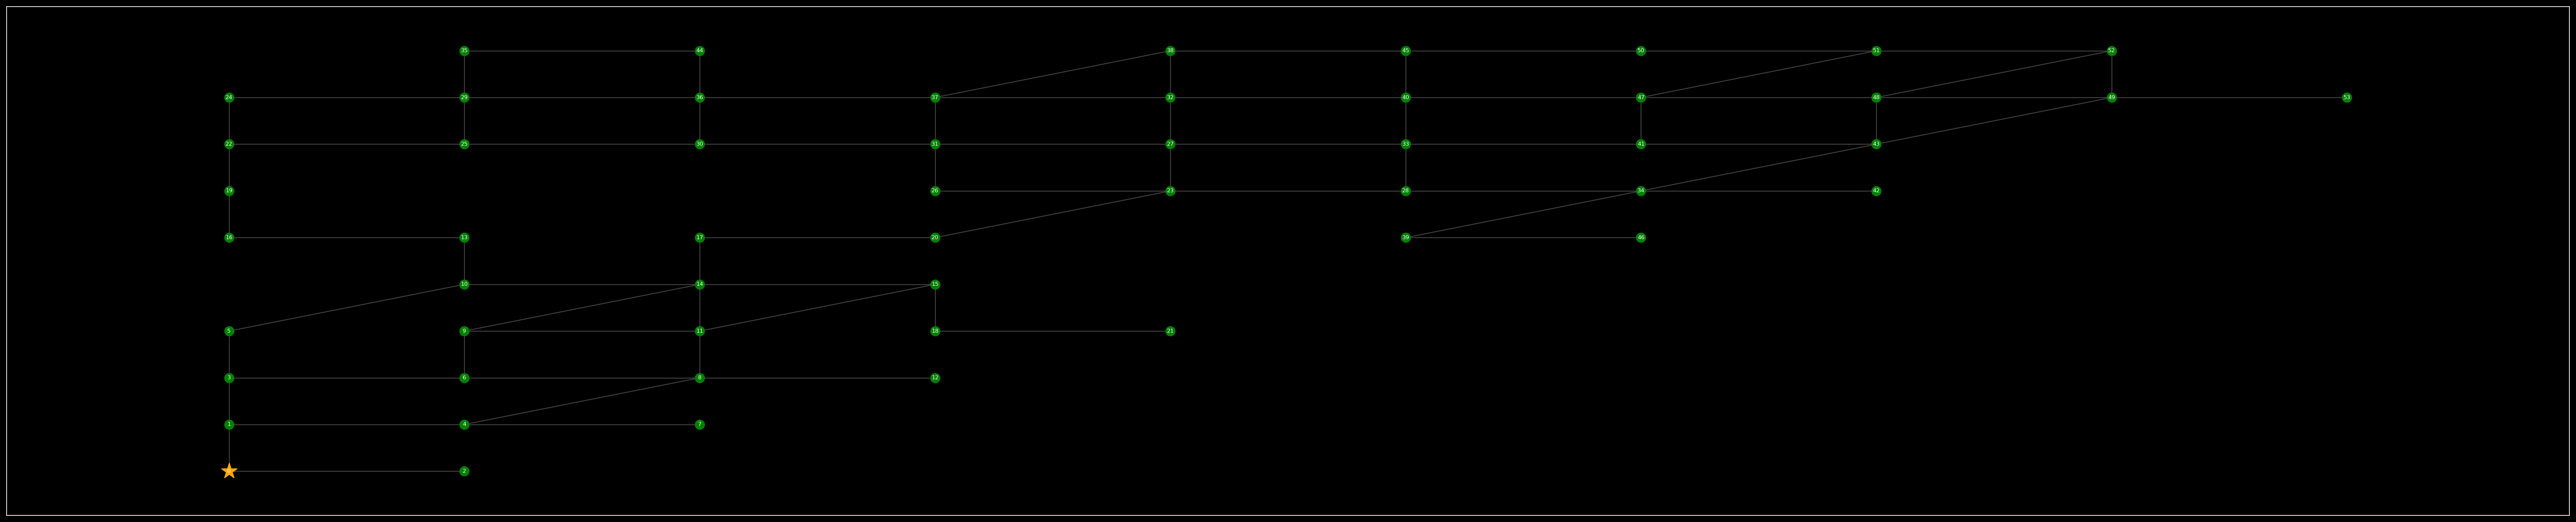

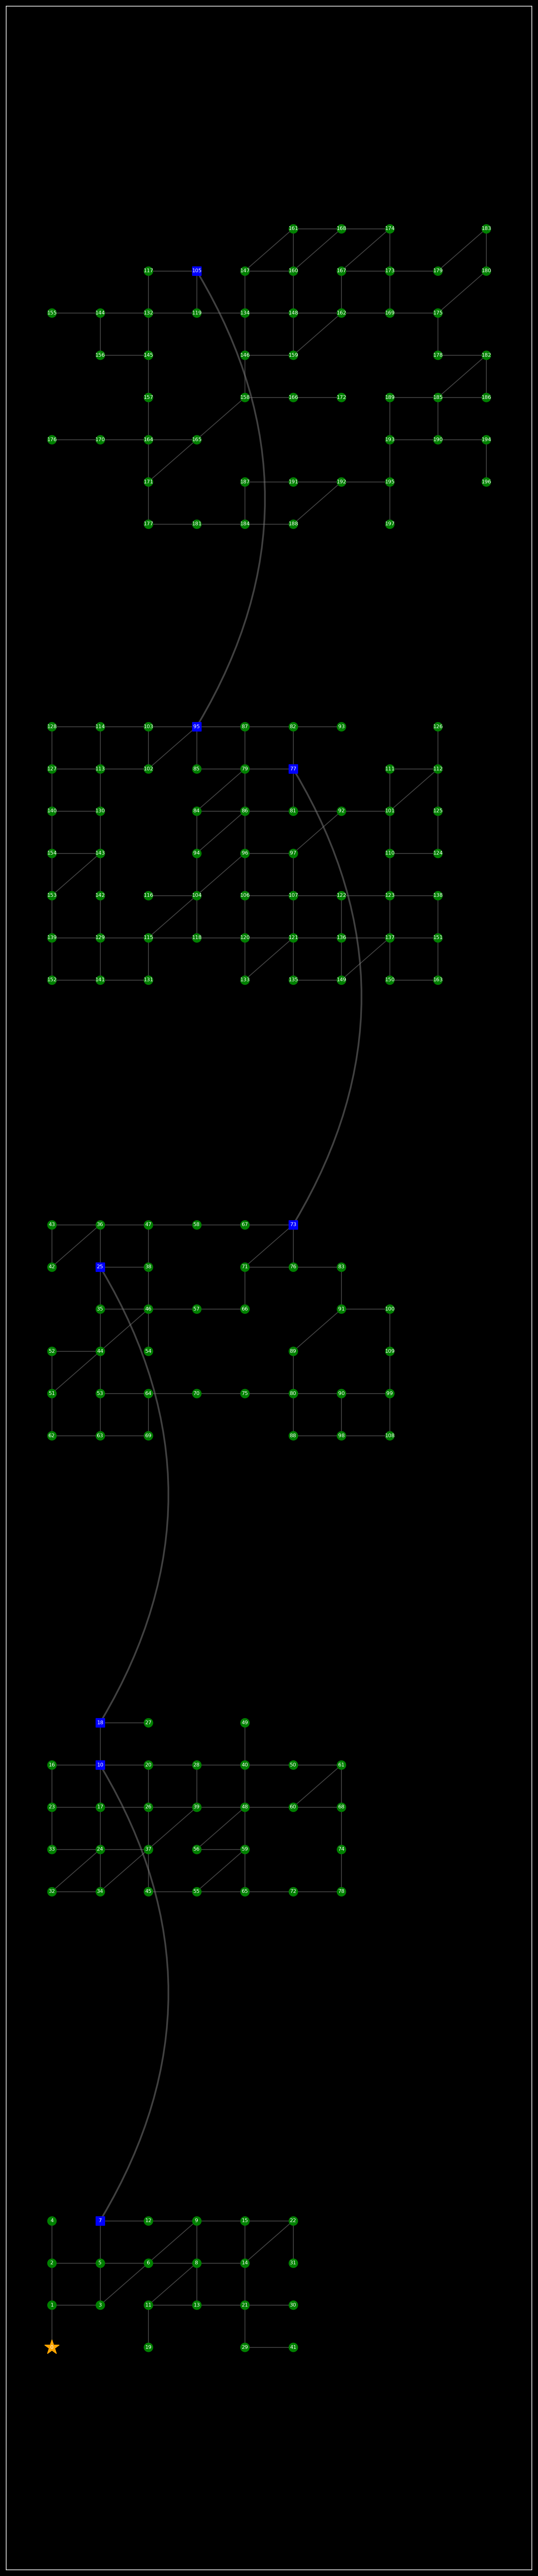

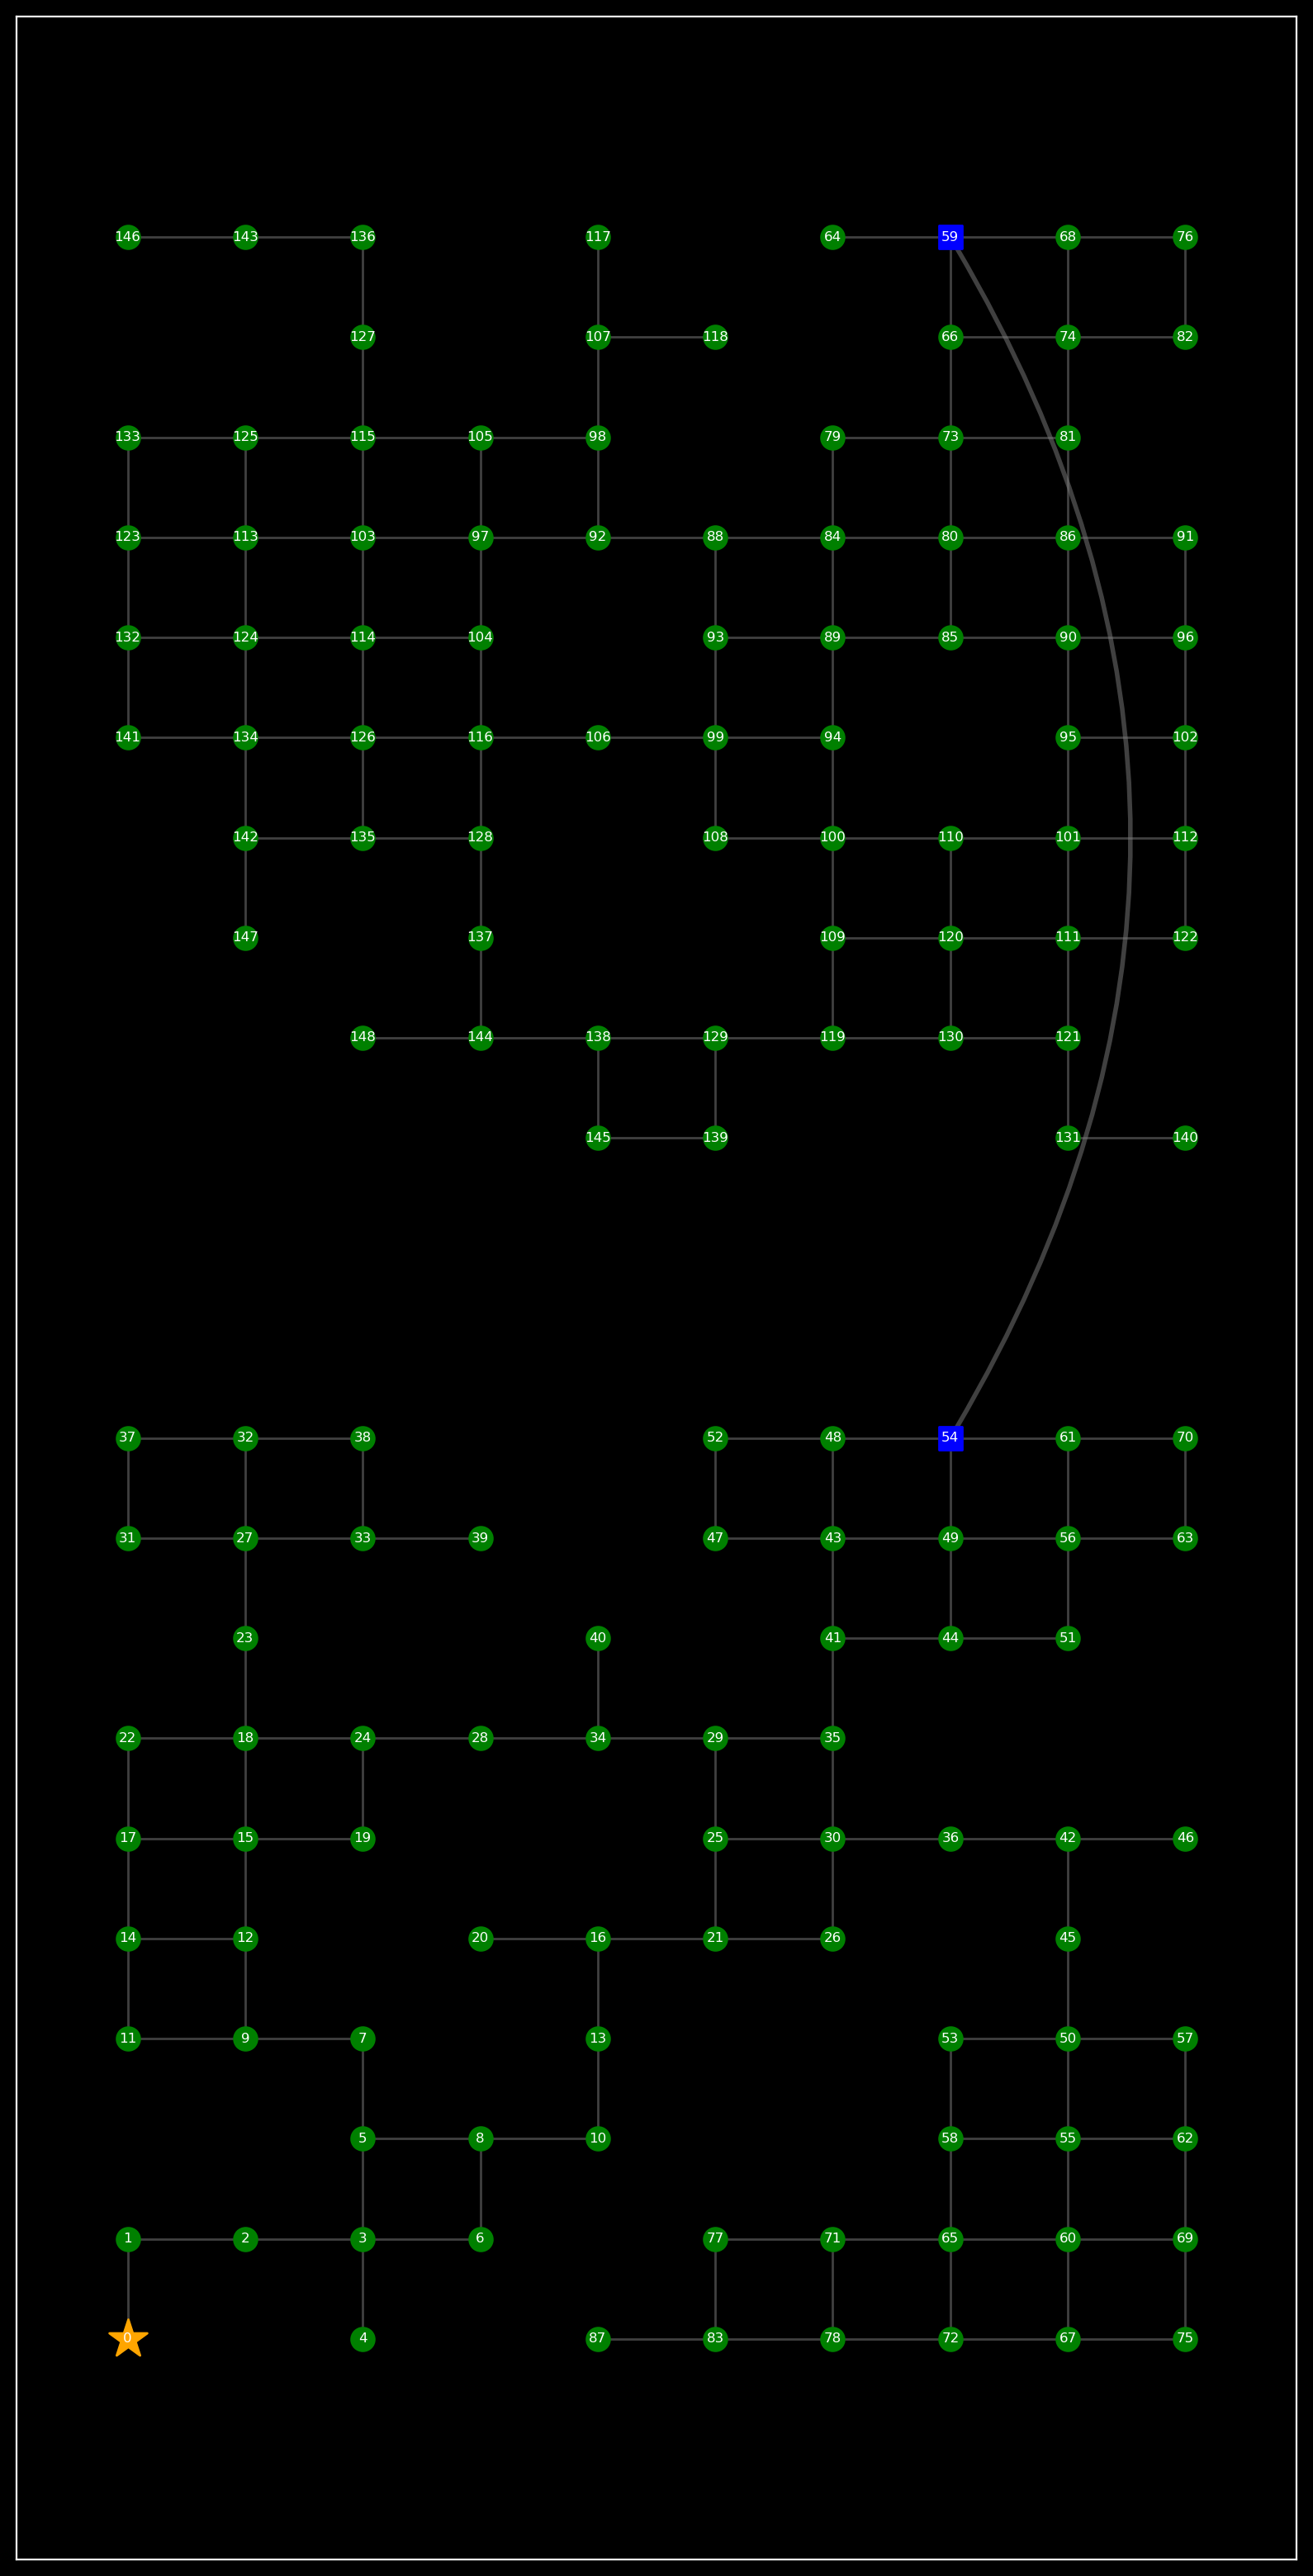

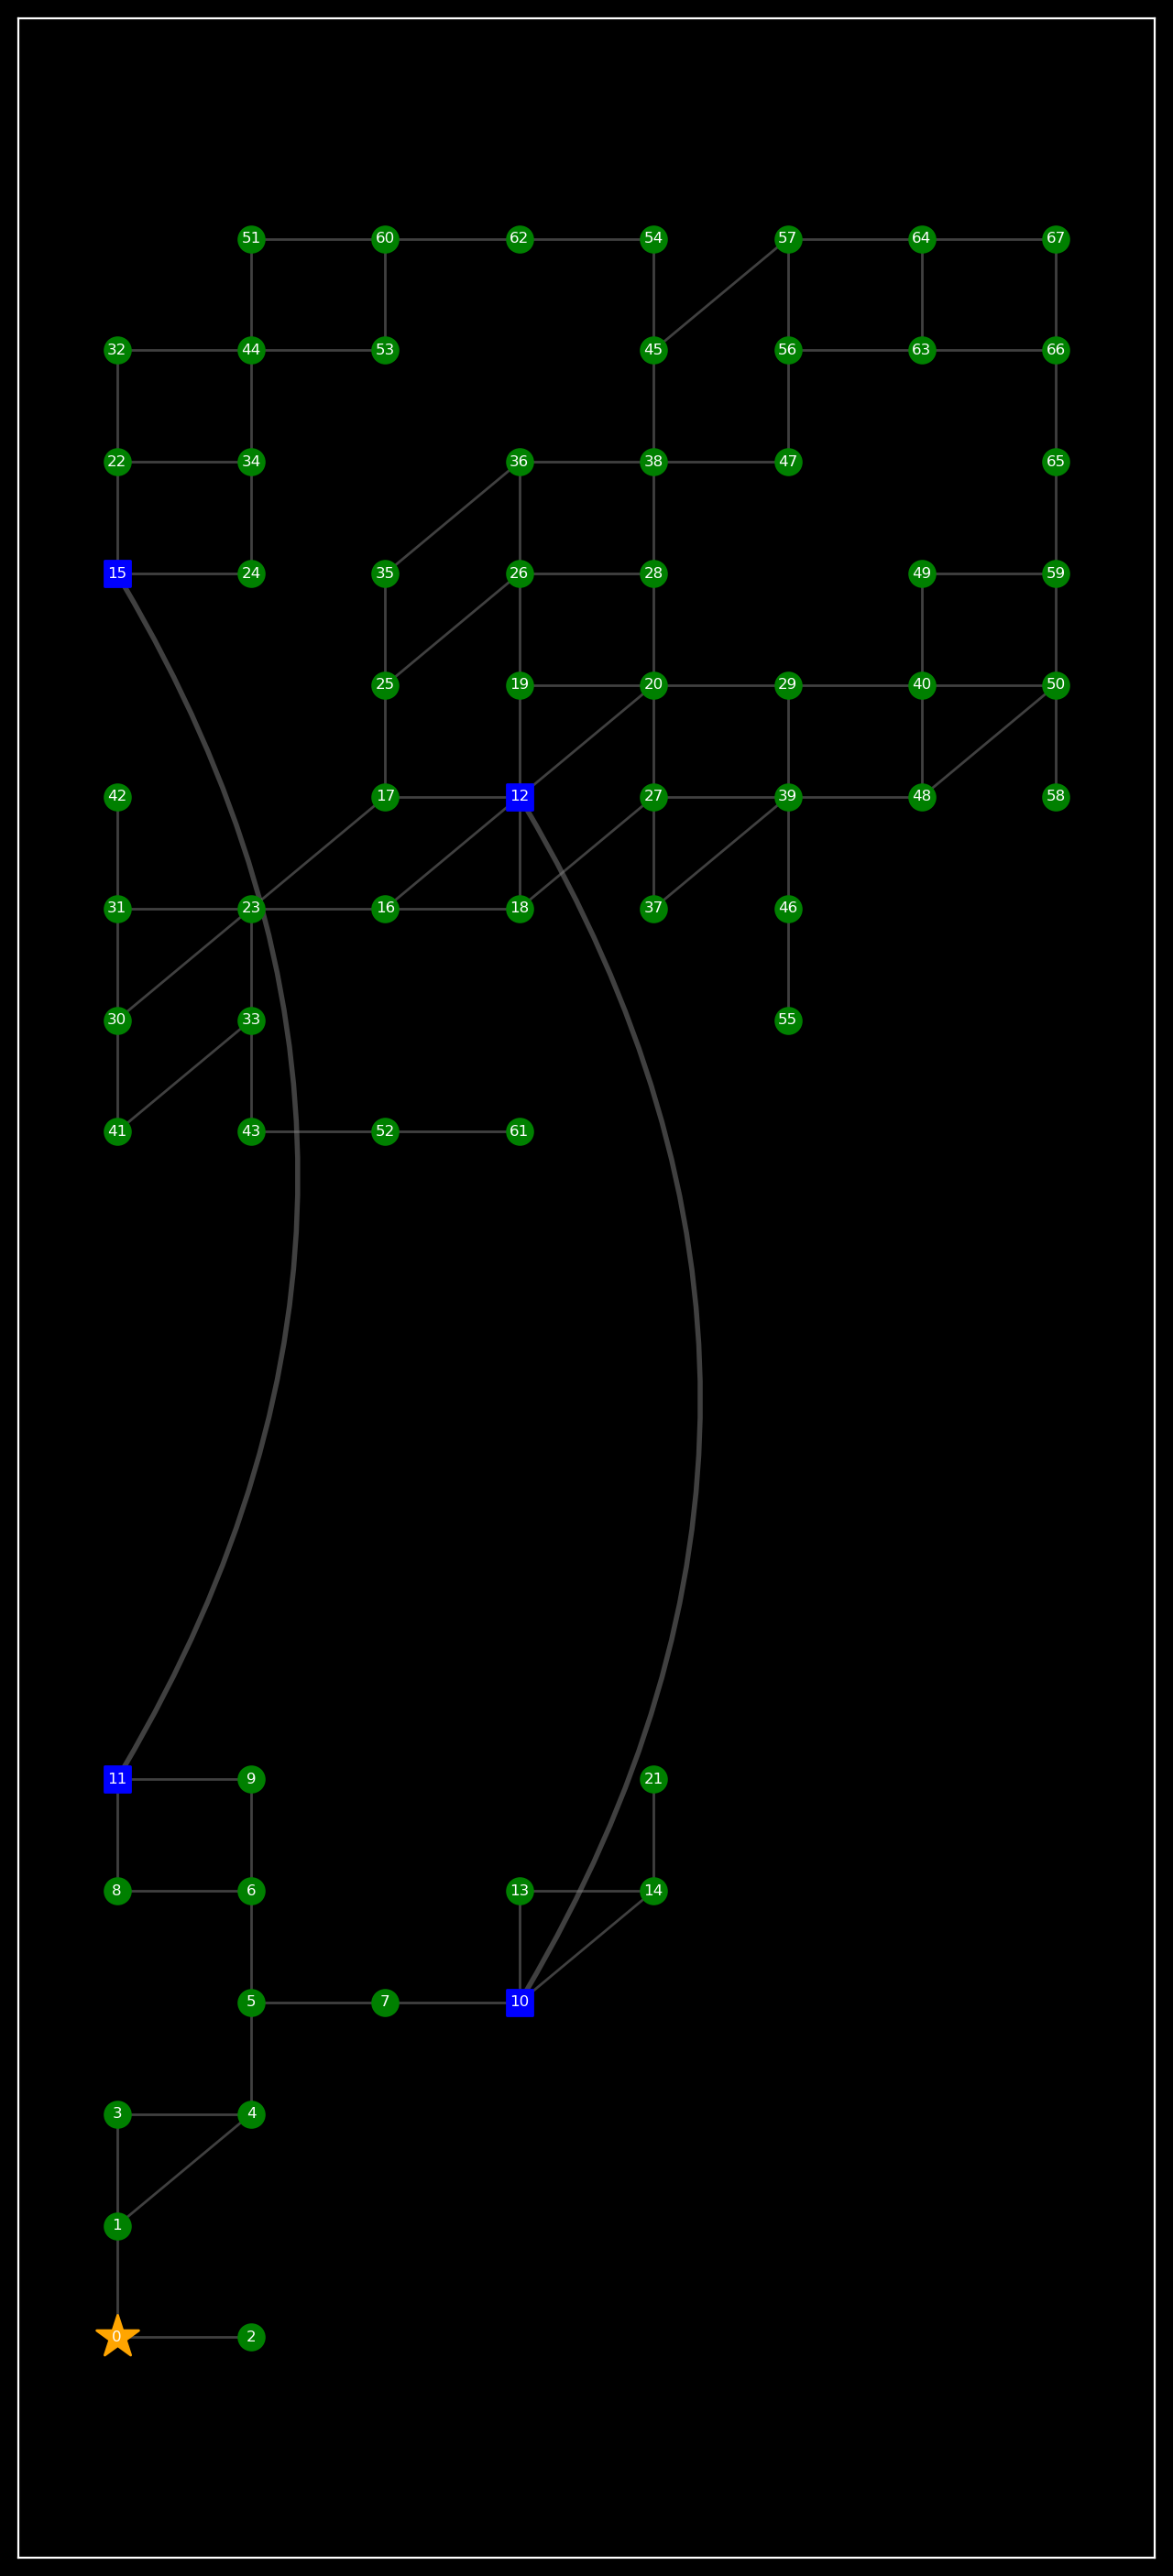

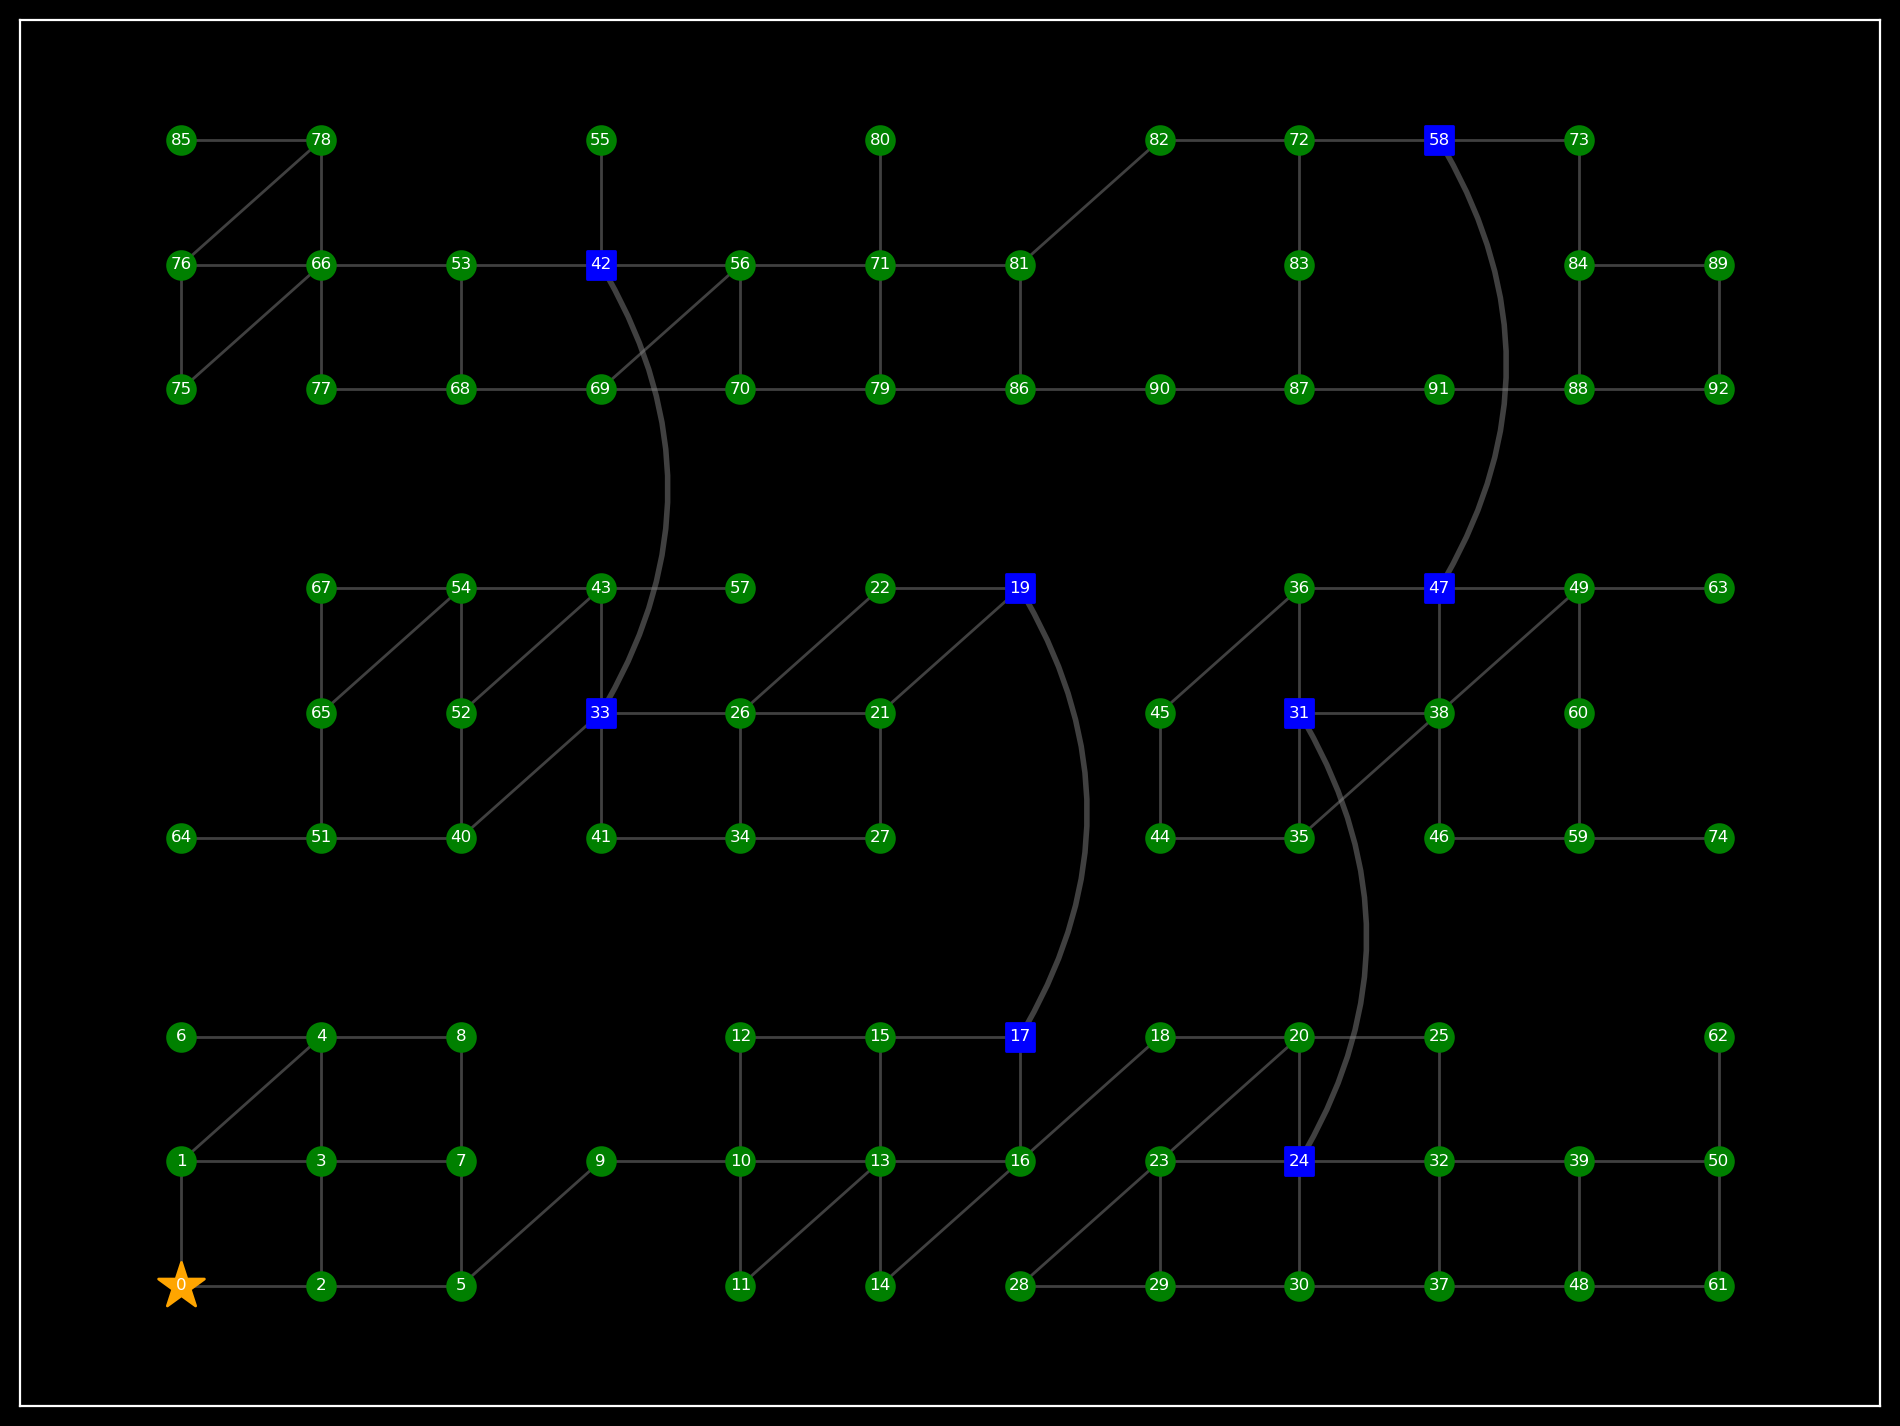

In [3]:
# 슬기 14문제 (diag -> 대각선 arc 생성)

# N=267, timelimit = 420 seconds, rehandling required?
P, H, W, L, F = 20, 15, 12, 2, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.25, total_allocation_ratio=0.8, min_demands=20, rnd_seed=1, inc=1, min_demand_interval=4, ramp_one=False, rnd_ramp_pos=True, asym_demand_prob=True)

display(prob.prob_info['N'])
display(prob.prob_info['K'])
prob.draw_graph()

prob.save_to_file("stage3_test/prob1.json", with_graph=True)

# N=342, timelimit = 300 seconds, rehandling required?
P, H, W, L, F = 18, 5, 20, 3, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.25, total_allocation_ratio=0.8, min_demands=20, rnd_seed=1, inc=2, min_demand_interval=4, ramp_one=False, rnd_ramp_pos=True, asym_demand_prob=True)

display(prob.prob_info['N'])
display(prob.prob_info['K'])
prob.draw_graph()

prob.save_to_file("stage3_test/prob2.json", with_graph=True)

# N=90, timelimit = 180 seconds, rehandling required
P, H, W, L, F = 15, 13, 17, 1, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.10, total_allocation_ratio=0.85, min_demands=20, rnd_seed=1, inc=2, min_demand_interval=4, tri = True, ramp_one=False, rnd_ramp_pos=True, asym_demand_prob=True)

display(prob.prob_info['N'])
display(prob.prob_info['K'])
prob.draw_graph()

prob.save_to_file("stage3_test/prob3.json", with_graph=True)

# N=106, timelimit = 120 seconds, rehandling required
P, H, W, L, F = 10, 4, 6, 3, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.05, total_allocation_ratio=0.85, min_demands=20, rnd_seed=1, inc=3, min_demand_interval=4, tri = True, ramp_one=True, rnd_ramp_pos=False, asym_demand_prob=True)

display(prob.prob_info['N'])
display(prob.prob_info['K'])
prob.draw_graph()

prob.save_to_file("stage3_test/prob4.json", with_graph=True)

# N=110, timelimit = 180 seconds, rehandling required
P, H, W, L, F = 15, 8, 8, 2, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.2, total_allocation_ratio=0.8, min_demands=20, rnd_seed=1, inc=1, min_demand_interval=4, tri = False, diag = True, ramp_one=True, rnd_ramp_pos=False, asym_demand_prob=False)

display(prob.prob_info['N'])
display(prob.prob_info['K'])
prob.draw_graph()

prob.save_to_file("stage3_test/prob5.json", with_graph=True)

# N=56, timelimit = 60 seconds, rehandling required
P, H, W, L, F = 12, 5, 7, 2, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.1, total_allocation_ratio=0.80, min_demands=20, rnd_seed=1, inc=3, min_demand_interval=3, tri = True, diag = True, ramp_one=True, rnd_ramp_pos=False, asym_demand_prob=False)

display(prob.prob_info['N'])
display(prob.prob_info['K'])
prob.draw_graph()

prob.save_to_file("stage3_test/prob6.json", with_graph=True)

# N=144, timelimit = 240 seconds, rehandling required?
P, H, W, L, F = 10, 6, 6, 3, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.2, total_allocation_ratio=0.80, min_demands=20, rnd_seed=1, inc=2, min_demand_interval=3, tri = False, diag = False, ramp_one=False, rnd_ramp_pos=False, asym_demand_prob=False)

display(prob.prob_info['N'])
display(prob.prob_info['K'])
prob.draw_graph()

prob.save_to_file("stage3_test/prob7.json", with_graph=True)


# N=115, timelimit = 180 seconds, rehandling required
P, H, W, L, F = 20, 10, 7, 2, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.2, total_allocation_ratio=0.80, min_demands=20, rnd_seed=7, inc=0, min_demand_interval=5, tri = False, diag = False, ramp_one=False, rnd_ramp_pos=False, asym_demand_prob=False)

display(prob.prob_info['N'])
display(prob.prob_info['K'])
prob.draw_graph()

prob.save_to_file("stage3_test/prob8.json", with_graph=True)


# N=63, timelimit = 60 seconds, rehandling required
P, H, W, L, F = 17, 16, 5, 1, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.15, total_allocation_ratio=0.80, min_demands=20, rnd_seed=7, inc=0, min_demand_interval=4, tri = False, diag = True, ramp_one=False, rnd_ramp_pos=False, asym_demand_prob=True)

display(prob.prob_info['N'])
display(prob.prob_info['K'])
prob.draw_graph()

prob.save_to_file("stage3_test/prob9.json", with_graph=True)

# N=54, timelimit = 120 seconds, rehandling required
P, H, W, L, F = 15, 10, 50, 1, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.15, total_allocation_ratio=0.82, min_demands=20, rnd_seed=3, inc=0, min_demand_interval=3, tri = True, diag = True, ramp_one=False, rnd_ramp_pos=False, asym_demand_prob=False)

display(prob.prob_info['N'])
display(prob.prob_info['K'])
prob.draw_graph()

prob.save_to_file("stage3_test/prob10.json", with_graph=True)

# N=198, timelimit = 240 seconds, rehandling required
P, H, W, L, F = 15, 4, 6, 6, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.2, total_allocation_ratio=0.8, min_demands=20, rnd_seed=4, inc=1, min_demand_interval=4, tri = False, diag = True, ramp_one=True, rnd_ramp_pos=True, asym_demand_prob=True)

display(prob.prob_info['N'])
display(prob.prob_info['K'])
prob.draw_graph()

prob.save_to_file("stage3_test/prob11.json", with_graph=True)

# N=149, timelimit = 120 seconds, rehandling required?
P, H, W, L, F = 13, 10, 10, 2, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.22, total_allocation_ratio=0.85, min_demands=20, rnd_seed=4, inc=0, min_demand_interval=3, tri = False, diag = False, ramp_one=True, rnd_ramp_pos=True, asym_demand_prob=True)

display(prob.prob_info['N'])
display(prob.prob_info['K'])
prob.draw_graph()

prob.save_to_file("stage3_test/prob12.json", with_graph=True)

# N=68, timelimit = 180 seconds, rehandling required
P, H, W, L, F = 8, 6, 5, 2, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.2, total_allocation_ratio=0.8, min_demands=20, rnd_seed=1, inc=3, min_demand_interval=4, tri = False, diag = True, ramp_one=False, rnd_ramp_pos=True, asym_demand_prob=False)

display(prob.prob_info['N'])
display(prob.prob_info['K'])
prob.draw_graph()

prob.save_to_file("stage3_test/prob13.json", with_graph=True)

# N=93, timelimit = 360 seconds, rehandling required
P, H, W, L, F = 25, 3, 12, 3, 100
prob = Prob(P, H, W, L, F, obstacle_ratio=0.1, total_allocation_ratio=0.8, min_demands=20, rnd_seed=1, inc=0, min_demand_interval=4, tri = False, diag = True, ramp_one=False, rnd_ramp_pos=True, asym_demand_prob=True)

display(prob.prob_info['N'])
display(prob.prob_info['K'])
prob.draw_graph()

prob.save_to_file("stage3_test/prob14.json", with_graph=True)



In [ ]:




probs = glob.glob('*.json', root_dir='stage3_test')


np.random.seed(2)

test_problems = np.random.choice(probs, 10, replace=False)
ex_problems = [p for p in probs if p not in test_problems]

print(f'{test_problems=}\n{ex_problems=}')




try:
    if os.path.exists('stage3_problems'):
        shutil.rmtree('stage3_problems')
    if os.path.exists('stage3_exercise_problems'):
        shutil.rmtree('stage3_exercise_problems')
    os.makedirs('stage3_problems', exist_ok=True)
    os.makedirs('stage3_exercise_problems', exist_ok=True)
except:
    pass



for idx,p in enumerate(test_problems):
   shutil.copyfile(f'stage3_test/{p}', f'stage3_problems/_{p}')
   os.rename(f'stage3_problems/_{p}', f'stage3_problems/prob{idx+1}.json')

for idx,p in enumerate(ex_problems):
    shutil.copyfile(f'stage3_test/{p}', f'stage3_exercise_problems/_{p}')
    os.rename(f'stage3_exercise_problems/_{p}', f'stage3_exercise_problems/prob{idx+1}.json')


test_problems=array(['prob5.json', 'prob1.json', 'prob14.json', 'prob7.json',
       'prob9.json', 'prob6.json', 'prob12.json', 'prob10.json',
       'prob3.json', 'prob4.json'], dtype='<U11')
ex_problems=['prob13.json', 'test.json', 'prob2.json', 'prob11.json', 'prob8.json']


In [8]:

# prob_file = probs[6]
probs = glob.glob('*.json', root_dir='stage3_test')

prob_folder = 'stage3_test'

for prob_file in probs:
    prob_info = json.load(open(f'{prob_folder}/{prob_file}', 'r'))

    P = prob_info['P']
    K = prob_info['K']

    new_P, new_K, unused_ports = remove_unused_ports(P, K)
    print(unused_ports)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
